In [195]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [196]:
#cargar archivos
df_result = pd.read_csv("../results/fechas_117/df_20250401_to_20250909_M20_preproc.csv") #cambiar la direccion
## calcular quienes son las firmas que entran al equilibrio!!
df_transado =pd.read_csv("../datos/procesado/df_despacho_agg.csv")
df_transado['FechaHora'] = pd.to_datetime(df_transado['FechaHora'])

#params
M=20  #ajustar
sub_dir='../results/fechas_117/' #cambiar la direccion

In [197]:
# Asegurar formato datetime
df_result['FechaHora'] = pd.to_datetime(df_result['FechaHora'])
df_transado['FechaHora'] = pd.to_datetime(df_transado['FechaHora'])

# Unir la demanda por FechaHora
df_result = df_result.merge(
    df_transado[['FechaHora', 'daily_eq_demand']],
    on='FechaHora',
    how='left'
)

# Ordenar por FechaHora y precio
df_result = df_result.sort_values(['FechaHora', 'precio'])

# Crear variable ganador iniciando en 0
df_result['ganador'] = 0

# Función que decide ganadores dentro de cada FechaHora
def asignar_ganadores(grupo):
    # Ordenar por precio ascendente
    grupo = grupo.sort_values('precio').reset_index(drop=True)

    demanda = grupo['daily_eq_demand'].iloc[0]
    suma = 0
    winners = []
    cumulatives = []

    for qty in grupo['cantidad_pos']:
        
        # El ganador es TRUE solo si la oferta completa cabe dentro de la demanda restante
        if suma + qty <= demanda:
            winners.append(1)
            suma += qty
        else:
            winners.append(0)
            suma += qty  # igual acumulamos para efectos de visualización

        cumulatives.append(suma)

    grupo['ganador'] = winners
    grupo['cumulative_qty'] = cumulatives

    return grupo


 

# Aplicar por FechaHora
df_result_gen = (
    df_result
    .groupby('FechaHora', group_keys=False)
    .apply(asignar_ganadores)
)

C:\Users\HP\AppData\Local\Temp\ipykernel_38764\544173161.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(asignar_ganadores)


In [198]:
df_result_gen

FechaHora CodigoPlanta   precio   cantidad  cantidad_pos  \
0  2025-04-01 00:00:00         HMIN    94.37   34000.00      34000.00   
1  2025-04-01 00:00:00         CLL1    94.37   63000.00      63000.00   
2  2025-04-01 00:00:00         TYP4   101.37   46000.00      46000.00   
3  2025-04-01 00:00:00         TYP3   101.37   49000.00      49000.00   
4  2025-04-01 00:00:00         TYP1   101.37   17507.26      17507.26   
..                 ...          ...      ...        ...           ...   
52 2025-09-09 23:00:00         TBQ4  1117.35   60000.00      60000.00   
53 2025-09-09 23:00:00         TVL1  1183.48  241000.00     241000.00   
54 2025-09-09 23:00:00         TEC1  1485.40  213000.00     213000.00   
55 2025-09-09 23:00:00         CTG2  1731.30   39000.00      39000.00   
56 2025-09-09 23:00:00         CTG1  1733.38   30000.00      30000.00   

         Fecha  cluster  gamma_thumb      EQpos          EdQb  \
0   2025-04-01       10     5.371719   34000.00 -4.356358e+03   
1   2025-04-01       10     6.038973   63000.00 -4.407591e+03   
2   2025-04-01       10     0.528870   46000.00 -7.713285e+03   
3   2025-04-01       10     5.332097   49000.00 -4.397277e+03   
4   2025-04-01       10     0.277062   17507.26 -5.425573e+03   
..         ...      ...          ...        ...           ...   
52  2025-09-09       12     0.500521   60000.00 -8.662953e-25   
53  2025-09-09       12     0.995918  241000.00 -2.303208e+03   
54  2025-09-09       12     0.747557  213000.00 -1.980057e+03   
55  2025-09-09       12     0.264999   39000.00 -8.119555e+02   
56  2025-09-09       12     0.238082   30000.00 -1.012298e+03   

    daily_eq_demand  ganador  cumulative_qty  
0           8634480        1        34000.00  
1           8634480        1        97000.00  
2           8634480        1       143000.00  
3           8634480        1       192000.00  
4           8634480        1       209507.26  
..              ...      ...             ...  
52          9877640        0     13578234.65  
53          9877640        0     13819234.65  
54          9877640        0     14032234.65  
55          9877640        0     14071234.65  
56          9877640        0     14101234.65  

[176194 rows x 13 columns]

In [199]:
#### tipo generador
df_desglose = pd.read_excel("../datos/raw/desglose.xlsx",header=3) #cambiar la direccion
df_result_gen['Fecha'] = pd.to_datetime(df_grouped['Fecha'])

df_result_gen = df_result_gen.merge(
    df_desglose[["Código SIC", "Tipo Generación"]],
    left_on="CodigoPlanta",
    right_on="Código SIC",
    how="left"
)
df_result_gen = df_result_gen.drop(columns=["Código SIC"])

In [200]:
df_result_gen['cantidad_pos'] = pd.to_numeric(df_result_gen['cantidad_pos'], errors='coerce')
df_result_gen

FechaHora CodigoPlanta   precio   cantidad  cantidad_pos  \
0      2025-04-01 00:00:00         HMIN    94.37   34000.00      34000.00   
1      2025-04-01 00:00:00         CLL1    94.37   63000.00      63000.00   
2      2025-04-01 00:00:00         TYP4   101.37   46000.00      46000.00   
3      2025-04-01 00:00:00         TYP3   101.37   49000.00      49000.00   
4      2025-04-01 00:00:00         TYP1   101.37   17507.26      17507.26   
...                    ...          ...      ...        ...           ...   
176189 2025-09-09 23:00:00         TBQ4  1117.35   60000.00      60000.00   
176190 2025-09-09 23:00:00         TVL1  1183.48  241000.00     241000.00   
176191 2025-09-09 23:00:00         TEC1  1485.40  213000.00     213000.00   
176192 2025-09-09 23:00:00         CTG2  1731.30   39000.00      39000.00   
176193 2025-09-09 23:00:00         CTG1  1733.38   30000.00      30000.00   

            Fecha  cluster  gamma_thumb      EQpos          EdQb  \
0      2025-04-01       10     5.371719   34000.00 -4.356358e+03   
1      2025-04-01       10     6.038973   63000.00 -4.407591e+03   
2      2025-04-01       10     0.528870   46000.00 -7.713285e+03   
3      2025-04-01       10     5.332097   49000.00 -4.397277e+03   
4      2025-04-01       10     0.277062   17507.26 -5.425573e+03   
...           ...      ...          ...        ...           ...   
176189 2025-04-01       12     0.500521   60000.00 -8.662953e-25   
176190 2025-04-01       12     0.995918  241000.00 -2.303208e+03   
176191 2025-04-01       12     0.747557  213000.00 -1.980057e+03   
176192 2025-04-01       12     0.264999   39000.00 -8.119555e+02   
176193 2025-04-01       12     0.238082   30000.00 -1.012298e+03   

        daily_eq_demand  ganador  cumulative_qty Tipo Generación  
0               8634480        1        34000.00      HIDRAULICA  
1               8634480        1        97000.00      HIDRAULICA  
2               8634480        1       143000.00         TERMICA  
3               8634480        1       192000.00         TERMICA  
4               8634480        1       209507.26         TERMICA  
...                 ...      ...             ...             ...  
176189          9877640        0     13578234.65         TERMICA  
176190          9877640        0     13819234.65         TERMICA  
176191          9877640        0     14032234.65         TERMICA  
176192          9877640        0     14071234.65         TERMICA  
176193          9877640        0     14101234.65         TERMICA  

[176194 rows x 14 columns]

In [201]:
df_result_gen2 = df_result_gen[df_result_gen['ganador'] == 1]
df_result_gen2

FechaHora CodigoPlanta  precio   cantidad  cantidad_pos  \
0      2025-04-01 00:00:00         HMIN   94.37   34000.00      34000.00   
1      2025-04-01 00:00:00         CLL1   94.37   63000.00      63000.00   
2      2025-04-01 00:00:00         TYP4  101.37   46000.00      46000.00   
3      2025-04-01 00:00:00         TYP3  101.37   49000.00      49000.00   
4      2025-04-01 00:00:00         TYP1  101.37   17507.26      17507.26   
...                    ...          ...     ...        ...           ...   
176165 2025-09-09 23:00:00         TSJ2  190.94  170000.00     170000.00   
176166 2025-09-09 23:00:00         TSJ1  216.94  165000.00     165000.00   
176167 2025-09-09 23:00:00         PPA3  232.95   70000.00      70000.00   
176168 2025-09-09 23:00:00         GEC3  244.02  164000.00     164000.00   
176169 2025-09-09 23:00:00         PPA4  289.45  165000.00     165000.00   

            Fecha  cluster  gamma_thumb      EQpos         EdQb  \
0      2025-04-01       10     5.371719   34000.00 -4356.357521   
1      2025-04-01       10     6.038973   63000.00 -4407.590934   
2      2025-04-01       10     0.528870   46000.00 -7713.284798   
3      2025-04-01       10     5.332097   49000.00 -4397.277283   
4      2025-04-01       10     0.277062   17507.26 -5425.573442   
...           ...      ...          ...        ...          ...   
176165 2025-04-01       12     2.180243  170000.00  -914.578812   
176166 2025-04-01       12     3.134335  165000.00  -832.423736   
176167 2025-04-01       12     1.818132   70000.00  -591.442412   
176168 2025-04-01       12     3.463637  164000.00  -977.865052   
176169 2025-04-01       12     3.733939  165000.00  -918.380672   

        daily_eq_demand  ganador  cumulative_qty Tipo Generación  
0               8634480        1        34000.00      HIDRAULICA  
1               8634480        1        97000.00      HIDRAULICA  
2               8634480        1       143000.00         TERMICA  
3               8634480        1       192000.00         TERMICA  
4               8634480        1       209507.26         TERMICA  
...                 ...      ...             ...             ...  
176165          9877640        1      9301234.65         TERMICA  
176166          9877640        1      9466234.65         TERMICA  
176167          9877640        1      9536234.65         TERMICA  
176168          9877640        1      9700234.65         TERMICA  
176169          9877640        1      9865234.65         TERMICA  

[92305 rows x 14 columns]

In [202]:
df_result_gen2[df_result_gen2['FechaHora'] == pd.Timestamp("2025-04-01 00:00:00")]



FechaHora CodigoPlanta  precio    cantidad  cantidad_pos      Fecha  \
0  2025-04-01         HMIN   94.37    34000.00      34000.00 2025-04-01   
1  2025-04-01         CLL1   94.37    63000.00      63000.00 2025-04-01   
2  2025-04-01         TYP4  101.37    46000.00      46000.00 2025-04-01   
3  2025-04-01         TYP3  101.37    49000.00      49000.00 2025-04-01   
4  2025-04-01         TYP1  101.37    17507.26      17507.26 2025-04-01   
5  2025-04-01         LTSJ  104.61   306000.00     306000.00 2025-04-01   
6  2025-04-01         CHVR  104.61   500000.00     500000.00 2025-04-01   
7  2025-04-01         PGUG  104.61   402392.03     402392.03 2025-04-01   
8  2025-04-01         HMLG  104.61   264000.00     264000.00 2025-04-01   
9  2025-04-01         CUC1  104.61    42000.00      42000.00 2025-04-01   
10 2025-04-01         SOG1  104.61   777000.00     777000.00 2025-04-01   
11 2025-04-01         SMI1  104.61    25000.00      25000.00 2025-04-01   
12 2025-04-01         PRDO  104.61    51000.00      51000.00 2025-04-01   
13 2025-04-01         PES1  104.61  1200000.00    1200000.00 2025-04-01   
14 2025-04-01         GTPE  104.61   490000.00     490000.00 2025-04-01   
15 2025-04-01         QUI1  104.61   374000.00     374000.00 2025-04-01   
16 2025-04-01         PLYS  111.12   138000.00     138000.00 2025-04-01   
17 2025-04-01         GTRG  111.13   460000.00     460000.00 2025-04-01   
18 2025-04-01         MOY1  111.94    75000.00      75000.00 2025-04-01   
19 2025-04-01         DVS1  112.37   100000.00     100000.00 2025-04-01   
20 2025-04-01         2QEK  113.37     5000.00       5000.00 2025-04-01   
21 2025-04-01         ALBG  127.37   405000.00     405000.00 2025-04-01   
22 2025-04-01         GVIO  162.37   944000.00     944000.00 2025-04-01   
23 2025-04-01         JAGS  165.37   170000.00     170000.00 2025-04-01   
24 2025-04-01         CHBG  185.37   486000.00     486000.00 2025-04-01   
25 2025-04-01         SNCR  217.37  1085000.00    1085000.00 2025-04-01   

    cluster  gamma_thumb       EQpos         EdQb  daily_eq_demand  ganador  \
0        10     5.371719    34000.00 -4356.357521          8634480        1   
1        10     6.038973    63000.00 -4407.590934          8634480        1   
2        10     0.528870    46000.00 -7713.284798          8634480        1   
3        10     5.332097    49000.00 -4397.277283          8634480        1   
4        10     0.277062    17507.26 -5425.573442          8634480        1   
5        10    13.019066   306000.00 -2292.998916          8634480        1   
6        10    17.648239   500000.00 -2765.886167          8634480        1   
7        10    15.722600   402392.03 -2229.339353          8634480        1   
8        10    13.705312   264000.00 -2060.209180          8634480        1   
9        10     3.864257    42000.00 -4973.962327          8634480        1   
10       10    20.627475   777000.00 -2530.019941          8634480        1   
11       10     4.626247    25000.00 -4650.941219          8634480        1   
12       10     5.116742    51000.00 -4743.122697          8634480        1   
13       10    25.654511  1200000.00 -1999.733168          8634480        1   
14       10    15.386017   490000.00 -2999.962061          8634480        1   
15       10    14.239037   374000.00 -2418.017471          8634480        1   
16       10    10.146375   138000.00 -3011.363379          8634480        1   
17       10    15.484100   460000.00 -2922.952949          8634480        1   
18       10     5.906569    75000.00 -4434.560573          8634480        1   
19       10     7.853056   100000.00 -3419.855413          8634480        1   
20       10     3.761274     5000.00 -4506.154025          8634480        1   
21       10    14.495284   405000.00 -2565.594713          8634480        1   
22       10    24.946481   944000.00 -1946.877108          8634480        1   
23       10     9.515933   170000.00 -3288.569042          8634480        1   
24 

In [203]:
#tabla de como es aporte por tipo de geenrador


df_result_gen['FechaHora'] = pd.to_datetime(df_result_gen['FechaHora'], errors='coerce')
df_result_gen['hour'] = pd.to_datetime(df_result_gen['FechaHora']).dt.hour

df_sum_daily = (
    df_result_gen
    .groupby(['FechaHora', 'Tipo Generación'])['cantidad_pos']
    .sum()
    .reset_index()
)
df_sum_daily['hour'] = pd.to_datetime(df_sum_daily['FechaHora']).dt.hour
df_promedio_hora = (
    df_sum_daily
    .groupby(['Tipo Generación', 'hour'])['cantidad_pos']
    .mean()
    .reset_index()
)

df_ratio = df_sum_daily.merge(
    df_transado[['FechaHora', 'daily_eq_demand']],
    on='FechaHora',
    how='left'
)



In [204]:
df_ratio

FechaHora Tipo Generación  cantidad_pos  hour  daily_eq_demand
0    2025-04-01 00:00:00      HIDRAULICA   10000392.03     0          8634480
1    2025-04-01 00:00:00         TERMICA    5097507.26     0          8634480
2    2025-04-01 01:00:00      HIDRAULICA   10000305.59     1          8343930
3    2025-04-01 01:00:00         TERMICA    5097139.89     1          8343930
4    2025-04-01 02:00:00      HIDRAULICA   10000343.11     2          8149800
...                  ...             ...           ...   ...              ...
7034 2025-09-09 21:00:00         TERMICA    4319000.00    21         11140860
7035 2025-09-09 22:00:00      HIDRAULICA    9677000.00    22         10420020
7036 2025-09-09 22:00:00         TERMICA    4319000.00    22         10420020
7037 2025-09-09 23:00:00      HIDRAULICA    9782234.65    23          9877640
7038 2025-09-09 23:00:00         TERMICA    4319000.00    23          9877640

[7039 rows x 5 columns]

In [205]:
df_result_gen

FechaHora CodigoPlanta   precio   cantidad  cantidad_pos  \
0      2025-04-01 00:00:00         HMIN    94.37   34000.00      34000.00   
1      2025-04-01 00:00:00         CLL1    94.37   63000.00      63000.00   
2      2025-04-01 00:00:00         TYP4   101.37   46000.00      46000.00   
3      2025-04-01 00:00:00         TYP3   101.37   49000.00      49000.00   
4      2025-04-01 00:00:00         TYP1   101.37   17507.26      17507.26   
...                    ...          ...      ...        ...           ...   
176189 2025-09-09 23:00:00         TBQ4  1117.35   60000.00      60000.00   
176190 2025-09-09 23:00:00         TVL1  1183.48  241000.00     241000.00   
176191 2025-09-09 23:00:00         TEC1  1485.40  213000.00     213000.00   
176192 2025-09-09 23:00:00         CTG2  1731.30   39000.00      39000.00   
176193 2025-09-09 23:00:00         CTG1  1733.38   30000.00      30000.00   

            Fecha  cluster  gamma_thumb      EQpos          EdQb  \
0      2025-04-01       10     5.371719   34000.00 -4.356358e+03   
1      2025-04-01       10     6.038973   63000.00 -4.407591e+03   
2      2025-04-01       10     0.528870   46000.00 -7.713285e+03   
3      2025-04-01       10     5.332097   49000.00 -4.397277e+03   
4      2025-04-01       10     0.277062   17507.26 -5.425573e+03   
...           ...      ...          ...        ...           ...   
176189 2025-04-01       12     0.500521   60000.00 -8.662953e-25   
176190 2025-04-01       12     0.995918  241000.00 -2.303208e+03   
176191 2025-04-01       12     0.747557  213000.00 -1.980057e+03   
176192 2025-04-01       12     0.264999   39000.00 -8.119555e+02   
176193 2025-04-01       12     0.238082   30000.00 -1.012298e+03   

        daily_eq_demand  ganador  cumulative_qty Tipo Generación  hour  
0               8634480        1        34000.00      HIDRAULICA     0  
1               8634480        1        97000.00      HIDRAULICA     0  
2               8634480        1       143000.00         TERMICA     0  
3               8634480        1       192000.00         TERMICA     0  
4               8634480        1       209507.26         TERMICA     0  
...                 ...      ...             ...             ...   ...  
176189          9877640        0     13578234.65         TERMICA    23  
176190          9877640        0     13819234.65         TERMICA    23  
176191          9877640        0     14032234.65         TERMICA    23  
176192          9877640        0     14071234.65         TERMICA    23  
176193          9877640        0     14101234.65         TERMICA    23  

[176194 rows x 15 columns]

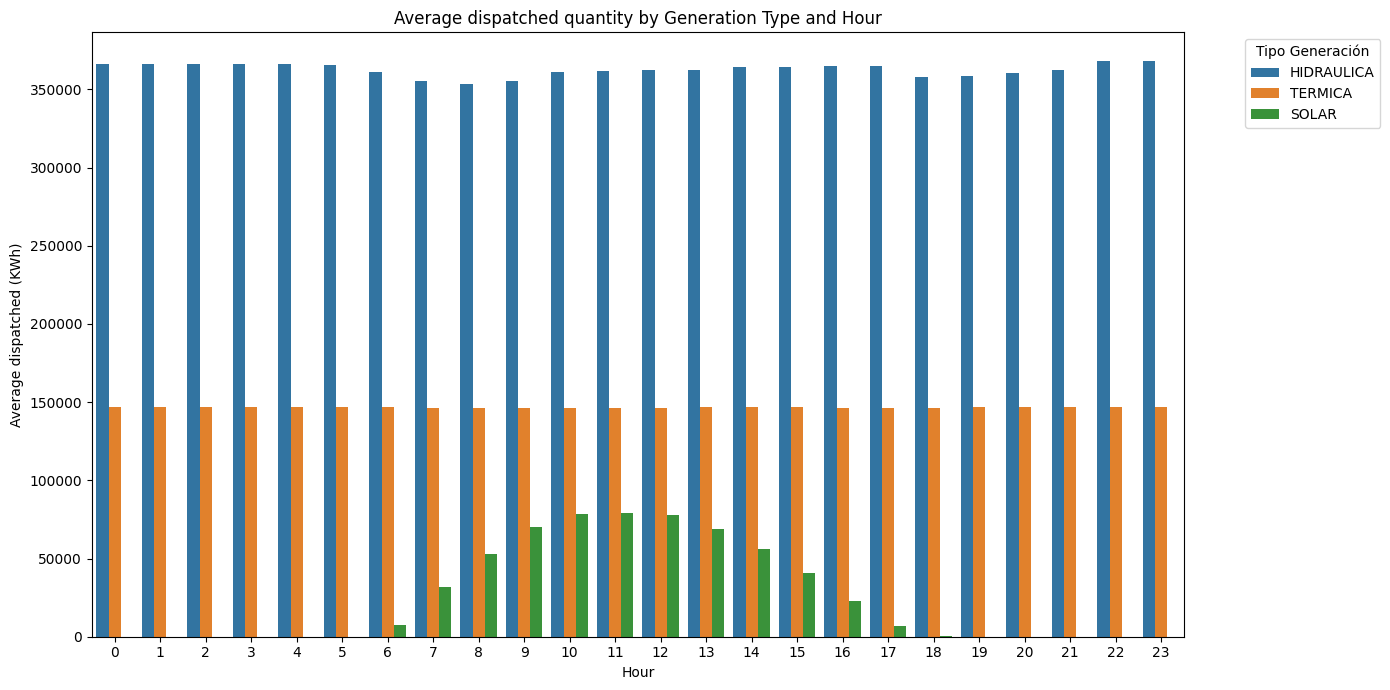

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurar que existe la columna hour
df_result_gen['hour'] = df_result_gen['FechaHora'].dt.hour

# Calcular promedios
df_promedios = (
    df_result_gen
    .groupby(['hour', 'Tipo Generación'])['cantidad_pos']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_promedios,
    x='hour',
    y='cantidad_pos',
    hue='Tipo Generación'
)

plt.title("Average dispatched quantity by Generation Type and Hour")
plt.xlabel("Hour")
plt.ylabel("Average dispatched (KWh)")
plt.legend(title="Tipo Generación", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [209]:
#solo para los gaandores

In [216]:
df_result=df_result_gen
df_result['ratio_prueba']= df_result['EQpos'] / df_result['EdQb']
df_result['Fecha'] = pd.to_datetime(df_result['Fecha'])
df_result['precio'] = pd.to_numeric(df_result['precio'], errors='coerce')


df_result['phi_h'] =  np.maximum(
    df_result['precio'] + np.where(
        df_result['EdQb'] != 0,
         (df_result['EQpos'] / df_result['EdQb']),
       0
    ),
    0
)


In [217]:
#agregar a nivel dia por empresa, esto es sumar h=1 hasta 23
# -------------------------------------------------------------------------
# Encontrar el termino  ∑_{h=0}^{23} E_{-it}[ Q_{ith} - pos_{ith} | s, p_{ht}=b_{it} ] )
# y el termino ( ∑_{h=0}^{23} E_{-it}[ ∂Q_{ith}/∂b_{it}    | s, p_{ht}=b_{it} ] )
# -------------------------------------------------------------------------

df_result['FechaHora'] = pd.to_datetime(df_result['FechaHora'], errors='coerce')
df_result['Fecha'] = df_result['FechaHora'].dt.date

df_grouped = (
    df_result.groupby(['Fecha', 'CodigoPlanta'], as_index=False)
      .agg(
          numerador=('EQpos', 'sum'),
          denominador=('EdQb', 'sum'),
          precio_d=('precio', 'max'),
          phi_agg=('phi_h', 'mean'), 
          ganador=('ganador', 'max'),
          available_q=('cantidad_pos', 'sum')
      )
)


#encontrar formula de costo marginal:
# -------------------------------------------------------------------------
#
#      φ_{it} = b_{it} +
#               ( ∑_{h=0}^{23} E_{-it}[ Q_{ith} - pos_{ith} | s, p_{ht}=b_{it} ] )
#               ----------------------------------------------------------------
#               ( ∑_{h=0}^{23} E_{-it}[ ∂Q_{ith}/∂b_{it}    | s, p_{ht}=b_{it} ] )
#
# -------------------------------------------------------------------------

# Evitar divisiones por cero
df_grouped['phi'] = np.maximum(
    df_grouped['precio_d'] + np.where(
        df_grouped['denominador'] != 0,
        df_grouped['numerador'] / df_grouped['denominador'],
        0
    ),
    0
)
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Fecha'])

In [218]:
df_grouped

Fecha CodigoPlanta   numerador   denominador  precio_d     phi_agg  \
0    2025-04-01         2QEK   120000.00 -63180.187366    113.37  108.864589   
1    2025-04-01         3DDT   861305.73 -33157.180533    107.37   73.801598   
2    2025-04-01         3ENA  4800000.00 -82282.458218    889.28  723.916433   
3    2025-04-01         3HF5   453773.97 -28667.935925    107.37   77.565072   
4    2025-04-01         3INX   275076.26 -27206.220316     97.37   77.961248   
...         ...          ...         ...           ...       ...         ...   
8087 2025-09-09         URA1  3096000.00 -11575.164763    118.94    6.959976   
8088 2025-09-09         ZPA2   468000.00  -7778.512512    372.94  305.805384   
8089 2025-09-09         ZPA3  1260000.00 -15419.687473    346.94  198.668968   
8090 2025-09-09         ZPA4  1280000.00 -11976.301401    360.94  200.584352   
8091 2025-09-09         ZPA5  1260000.00 -14355.057980    338.94  189.451097   

      ganador  available_q         phi  
0           1    120000.00  111.470670  
1           1    861305.73   81.393553  
2           0   4800000.00  830.944358  
3           1    453773.97   91.541376  
4           1    275076.26   87.259214  
...       ...          ...         ...  
8087        1   3096000.00    0.000000  
8088        1    864000.00  312.774255  
8089        1   1512000.00  265.226282  
8090        1   1536000.00  254.062262  
8091        1   1512000.00  251.166060  

[8092 rows x 9 columns]

In [219]:
df_desglose = pd.read_excel("../datos/raw/desglose.xlsx",header=3) #cambiar la direccion
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Fecha'])

df_merged = df_grouped.merge(
    df_desglose[["Código SIC", "Tipo Generación"]],
    left_on="CodigoPlanta",
    right_on="Código SIC",
    how="left"
)
df_merged = df_merged.drop(columns=["Código SIC"])

In [220]:
df_merged

Fecha CodigoPlanta   numerador   denominador  precio_d     phi_agg  \
0    2025-04-01         2QEK   120000.00 -63180.187366    113.37  108.864589   
1    2025-04-01         3DDT   861305.73 -33157.180533    107.37   73.801598   
2    2025-04-01         3ENA  4800000.00 -82282.458218    889.28  723.916433   
3    2025-04-01         3HF5   453773.97 -28667.935925    107.37   77.565072   
4    2025-04-01         3INX   275076.26 -27206.220316     97.37   77.961248   
...         ...          ...         ...           ...       ...         ...   
8087 2025-09-09         URA1  3096000.00 -11575.164763    118.94    6.959976   
8088 2025-09-09         ZPA2   468000.00  -7778.512512    372.94  305.805384   
8089 2025-09-09         ZPA3  1260000.00 -15419.687473    346.94  198.668968   
8090 2025-09-09         ZPA4  1280000.00 -11976.301401    360.94  200.584352   
8091 2025-09-09         ZPA5  1260000.00 -14355.057980    338.94  189.451097   

      ganador  available_q         phi Tipo Generación  
0           1    120000.00  111.470670      HIDRAULICA  
1           1    861305.73   81.393553           SOLAR  
2           0   4800000.00  830.944358         TERMICA  
3           1    453773.97   91.541376           SOLAR  
4           1    275076.26   87.259214           SOLAR  
...       ...          ...         ...             ...  
8087        1   3096000.00    0.000000      HIDRAULICA  
8088        1    864000.00  312.774255         TERMICA  
8089        1   1512000.00  265.226282         TERMICA  
8090        1   1536000.00  254.062262         TERMICA  
8091        1   1512000.00  251.166060         TERMICA  

[8092 rows x 10 columns]

## Graficar

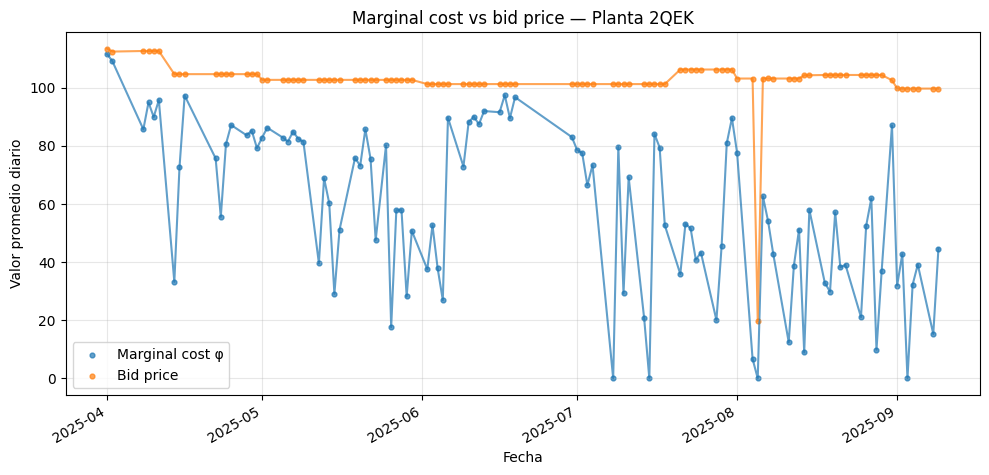

../results/fechas_117/phi_precio_2QEK_20250401_to_20250909_M20.png


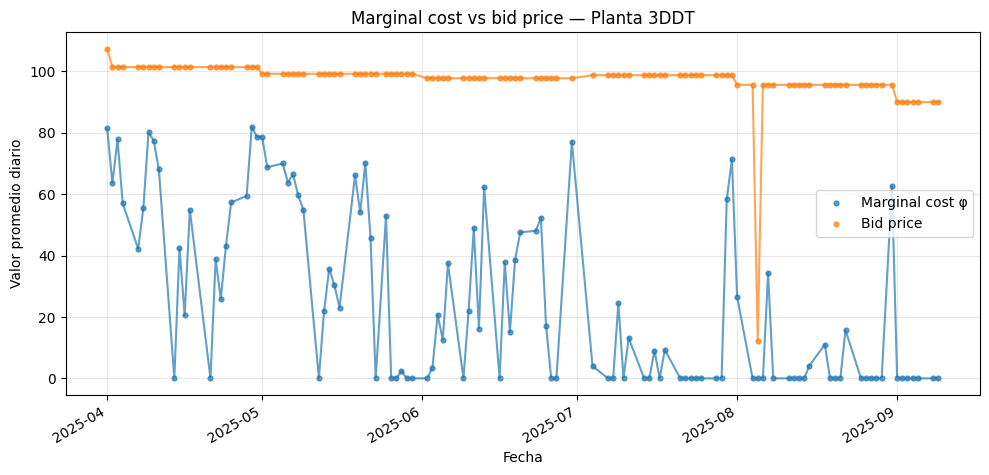

../results/fechas_117/phi_precio_3DDT_20250401_to_20250909_M20.png


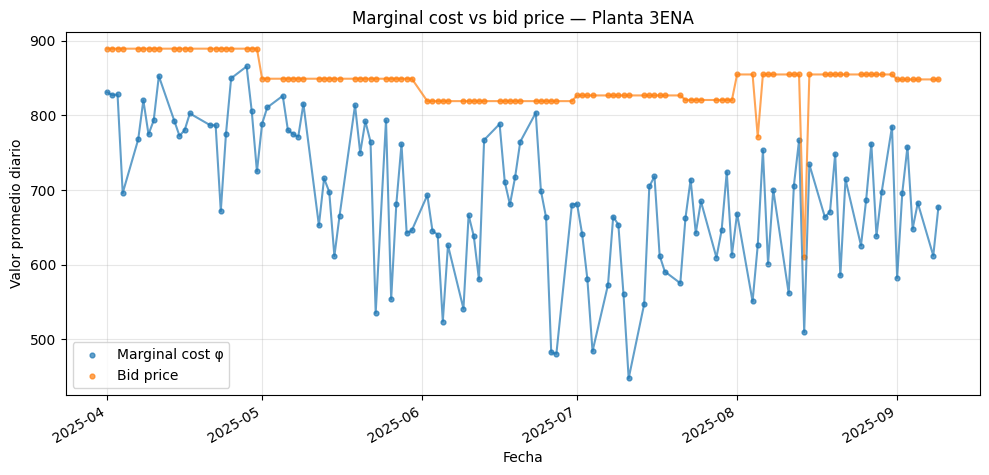

../results/fechas_117/phi_precio_3ENA_20250401_to_20250909_M20.png


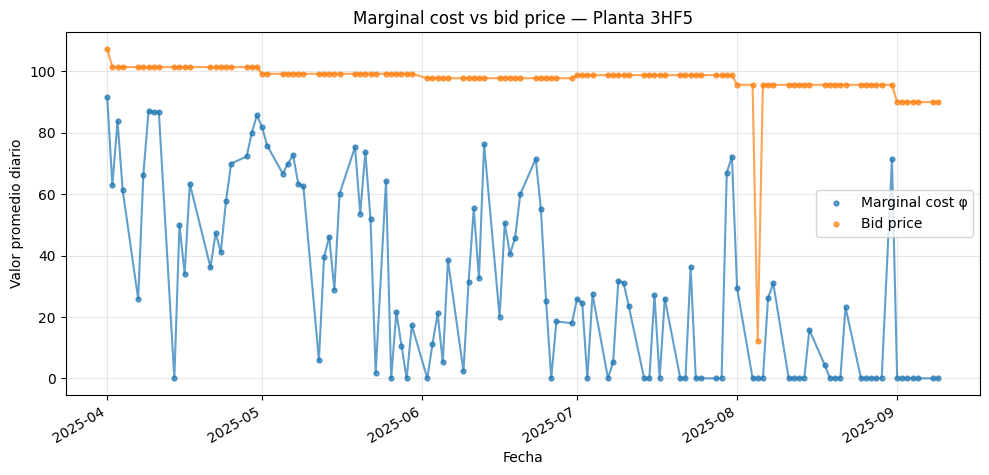

../results/fechas_117/phi_precio_3HF5_20250401_to_20250909_M20.png


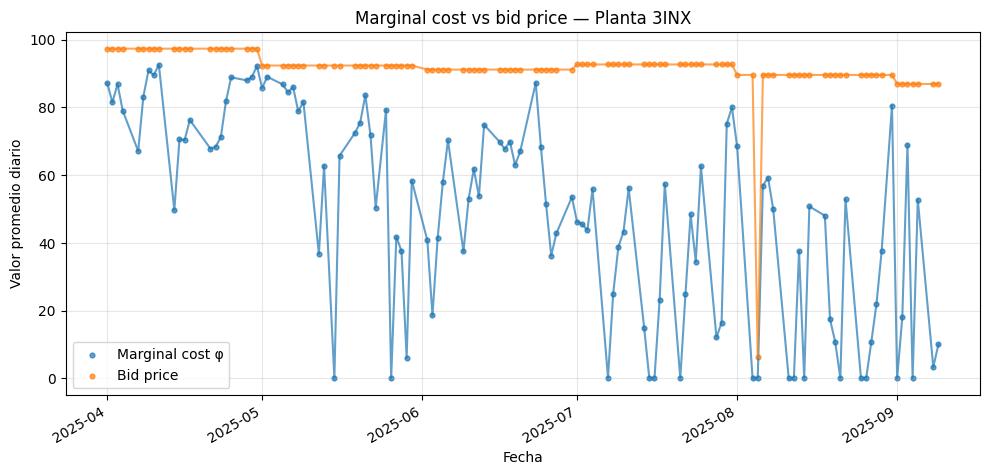

../results/fechas_117/phi_precio_3INX_20250401_to_20250909_M20.png


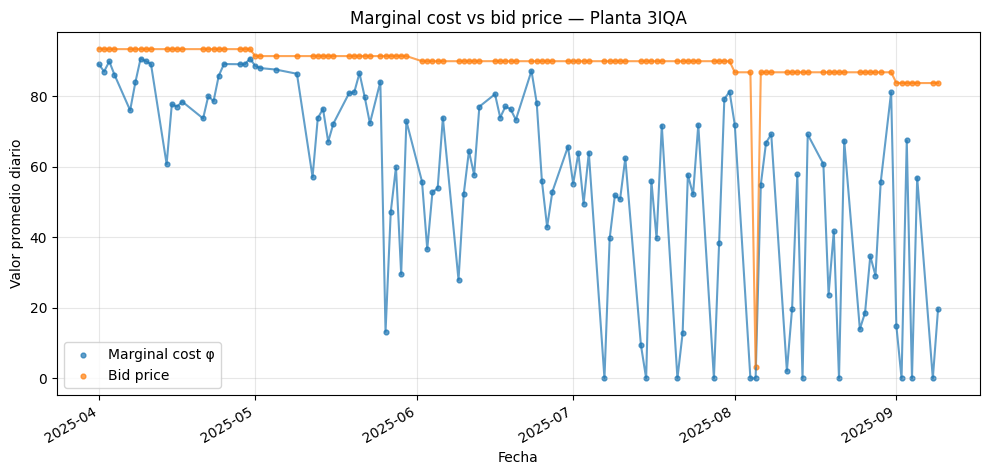

../results/fechas_117/phi_precio_3IQA_20250401_to_20250909_M20.png


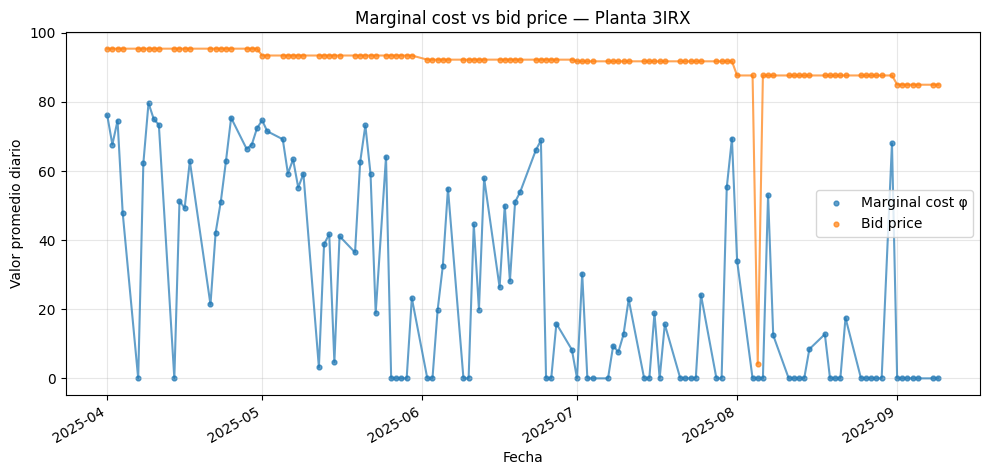

../results/fechas_117/phi_precio_3IRX_20250401_to_20250909_M20.png


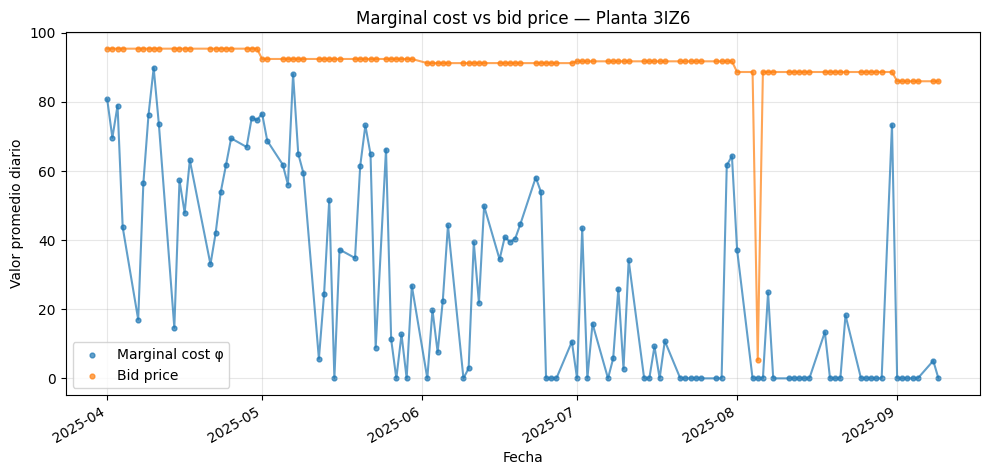

../results/fechas_117/phi_precio_3IZ6_20250401_to_20250909_M20.png


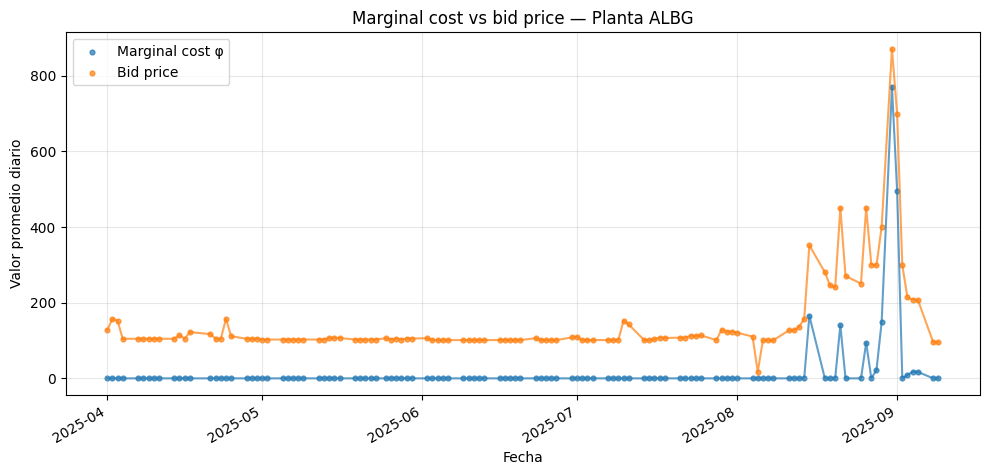

../results/fechas_117/phi_precio_ALBG_20250401_to_20250909_M20.png


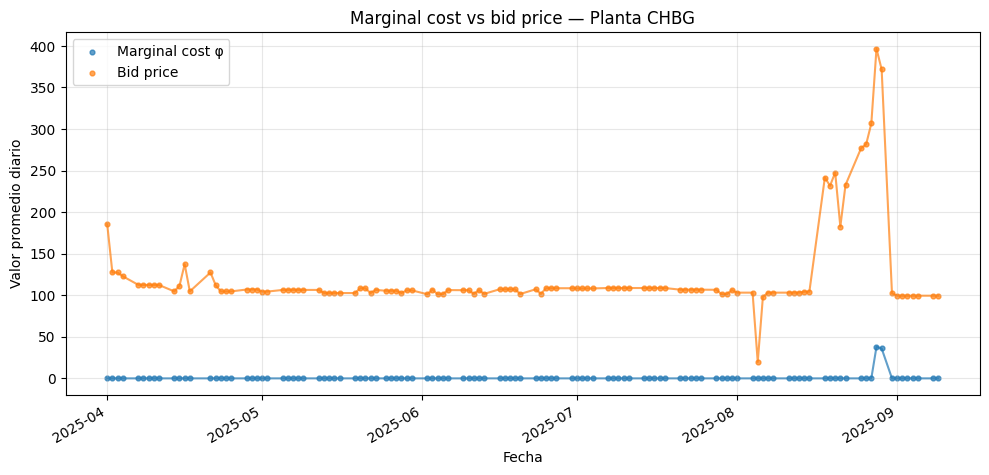

../results/fechas_117/phi_precio_CHBG_20250401_to_20250909_M20.png


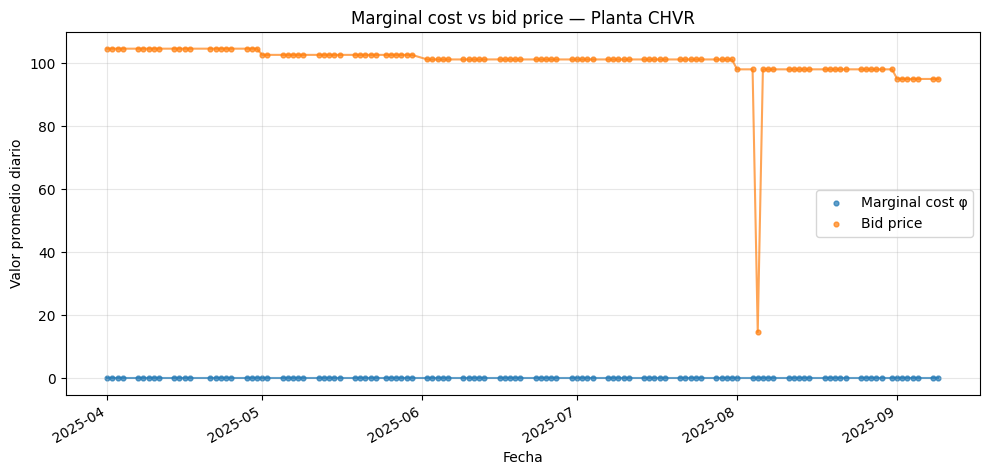

../results/fechas_117/phi_precio_CHVR_20250401_to_20250909_M20.png


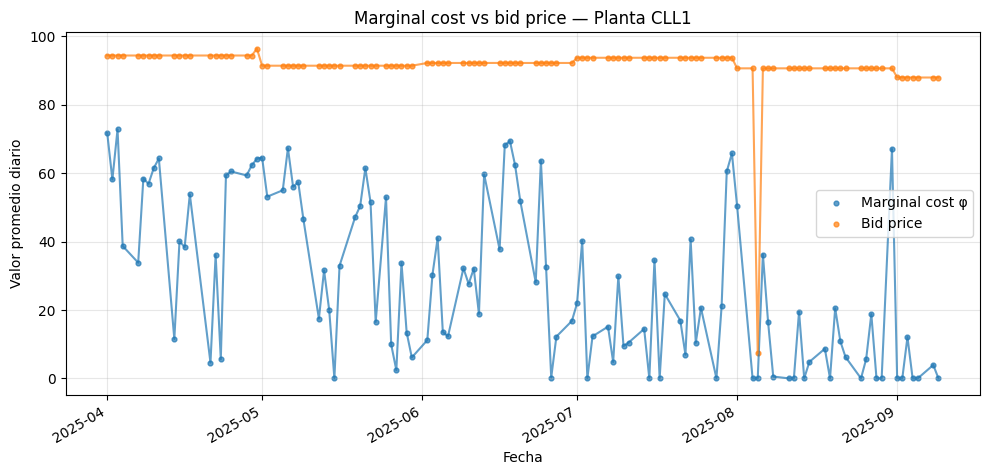

../results/fechas_117/phi_precio_CLL1_20250401_to_20250909_M20.png


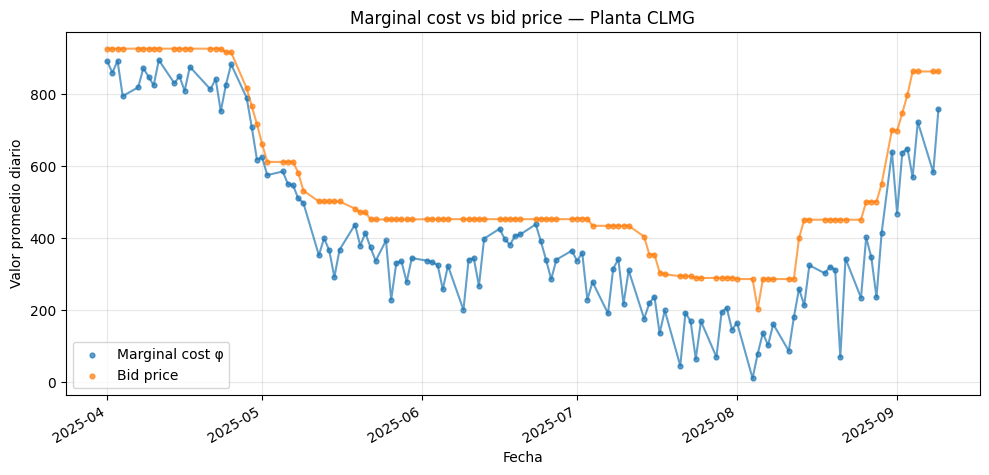

../results/fechas_117/phi_precio_CLMG_20250401_to_20250909_M20.png


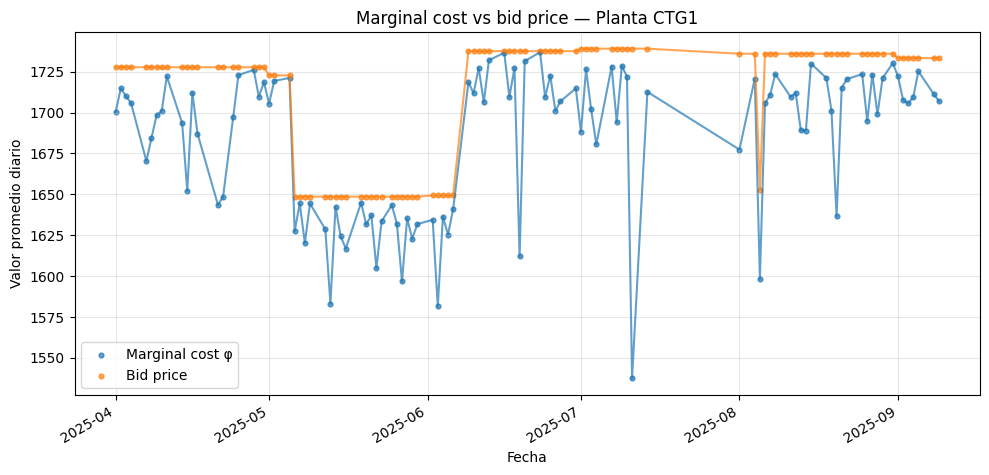

../results/fechas_117/phi_precio_CTG1_20250401_to_20250909_M20.png


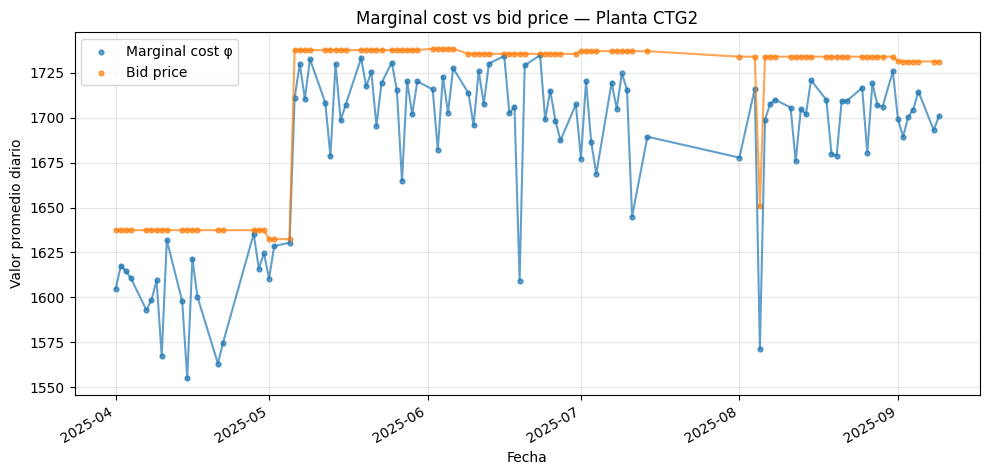

../results/fechas_117/phi_precio_CTG2_20250401_to_20250909_M20.png


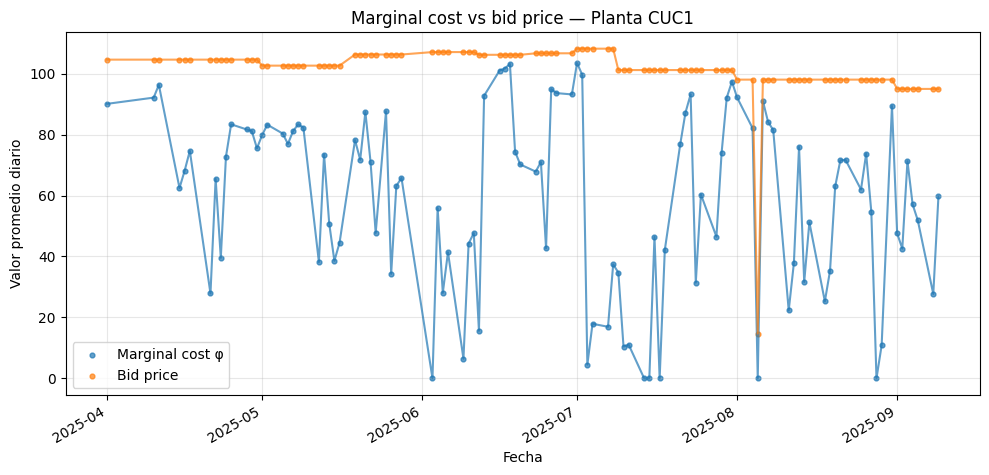

../results/fechas_117/phi_precio_CUC1_20250401_to_20250909_M20.png


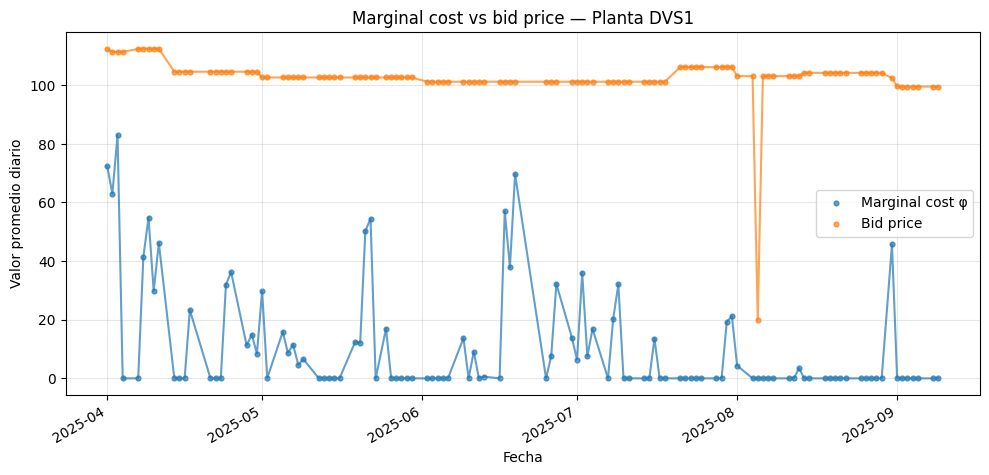

../results/fechas_117/phi_precio_DVS1_20250401_to_20250909_M20.png


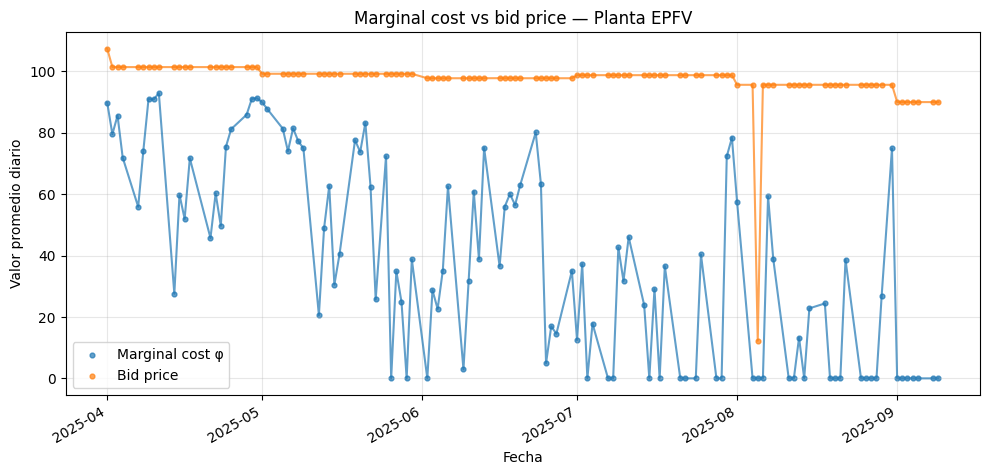

../results/fechas_117/phi_precio_EPFV_20250401_to_20250909_M20.png


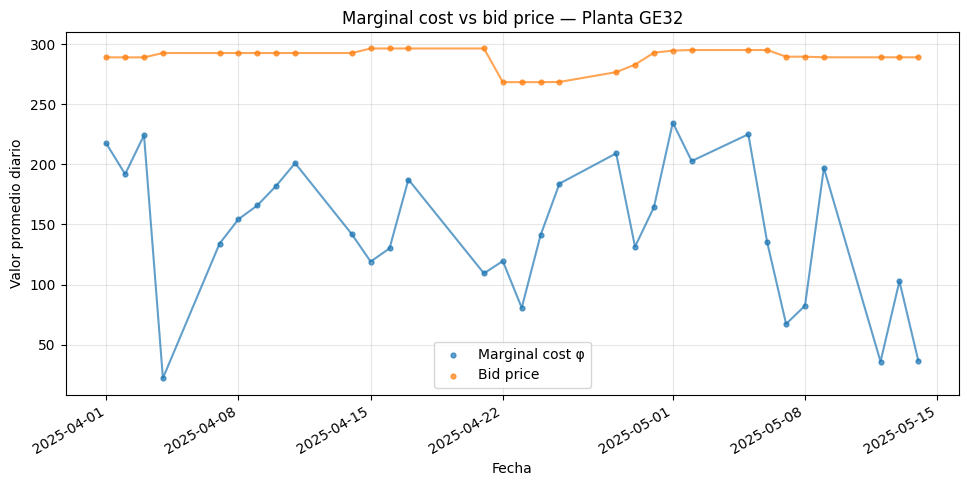

../results/fechas_117/phi_precio_GE32_20250401_to_20250514_M20.png


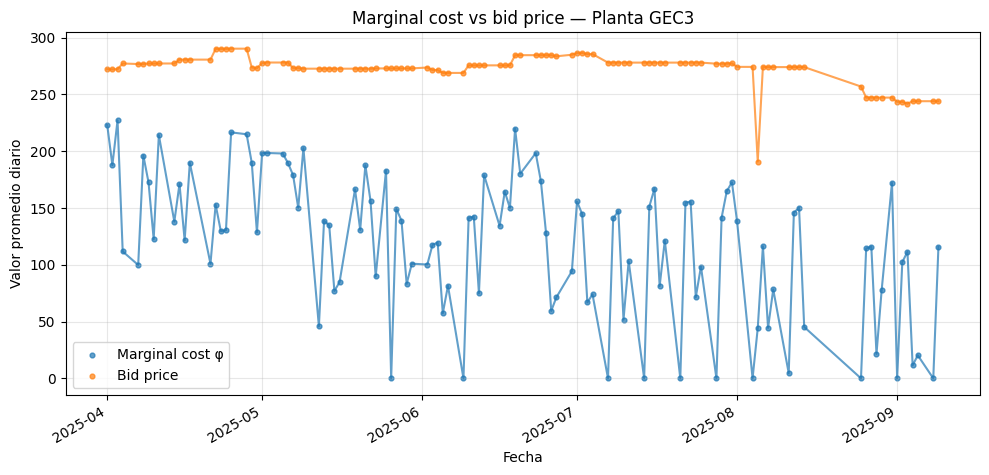

../results/fechas_117/phi_precio_GEC3_20250401_to_20250909_M20.png


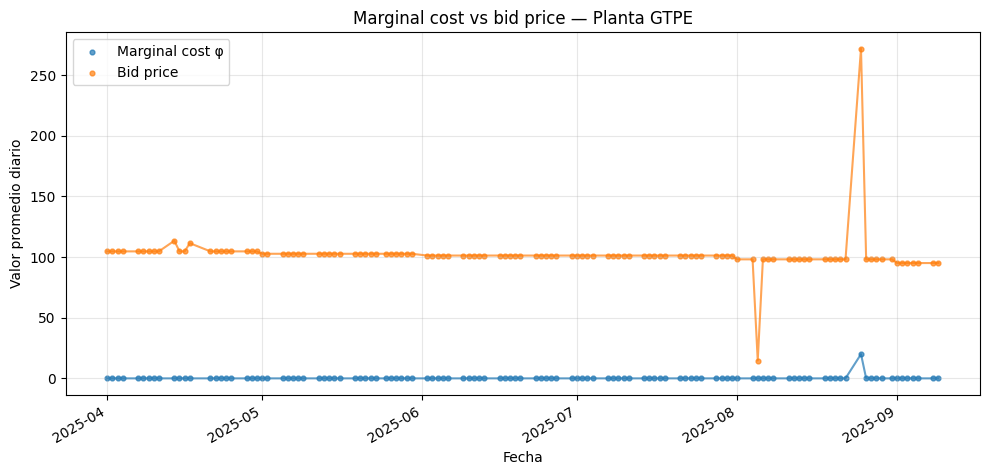

../results/fechas_117/phi_precio_GTPE_20250401_to_20250909_M20.png


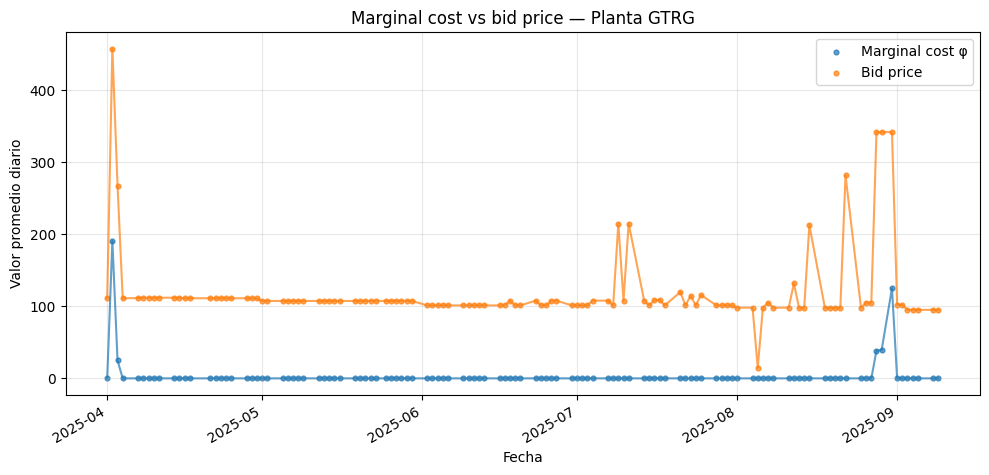

../results/fechas_117/phi_precio_GTRG_20250401_to_20250909_M20.png


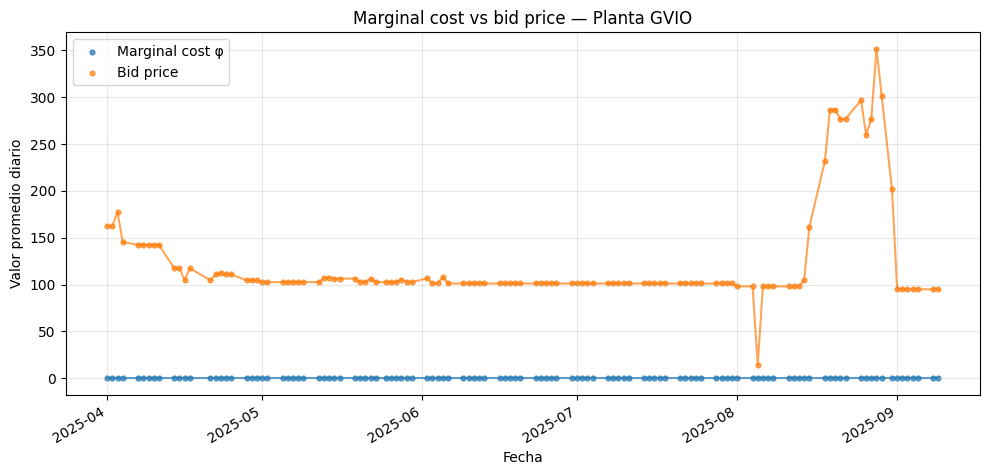

../results/fechas_117/phi_precio_GVIO_20250401_to_20250909_M20.png


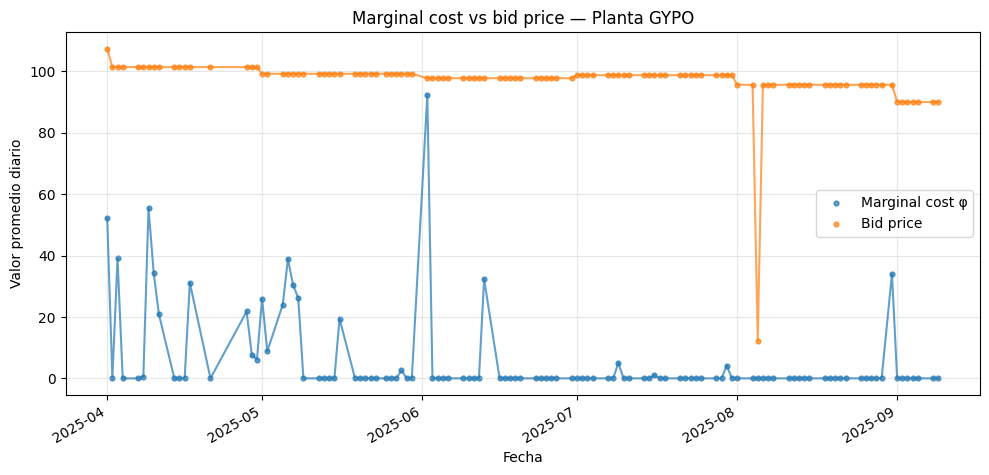

../results/fechas_117/phi_precio_GYPO_20250401_to_20250909_M20.png


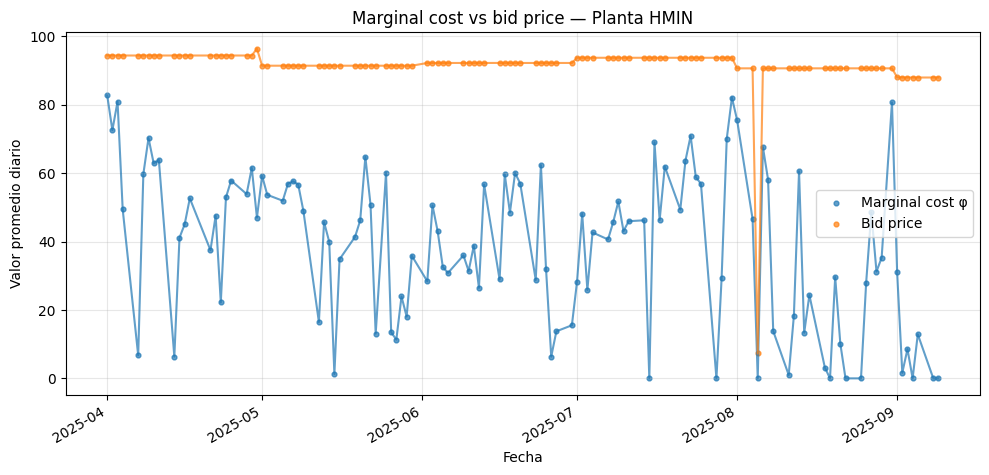

../results/fechas_117/phi_precio_HMIN_20250401_to_20250909_M20.png


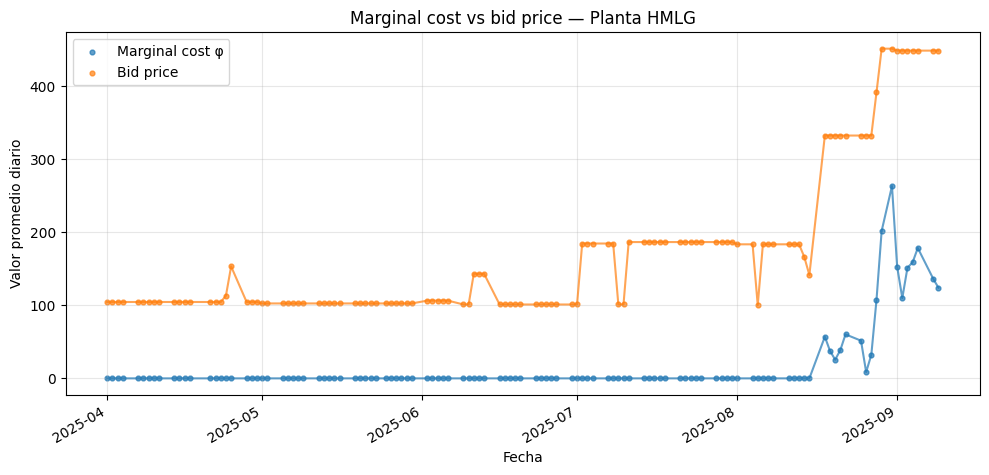

../results/fechas_117/phi_precio_HMLG_20250401_to_20250909_M20.png


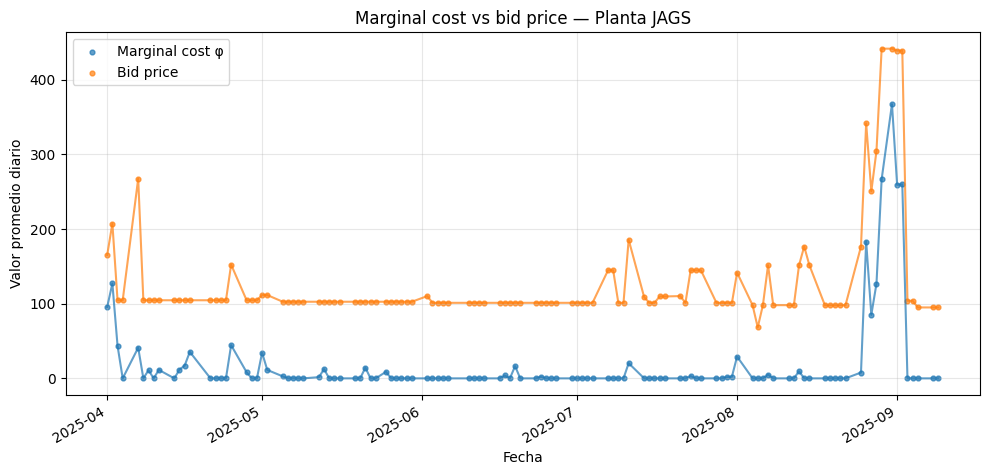

../results/fechas_117/phi_precio_JAGS_20250401_to_20250909_M20.png


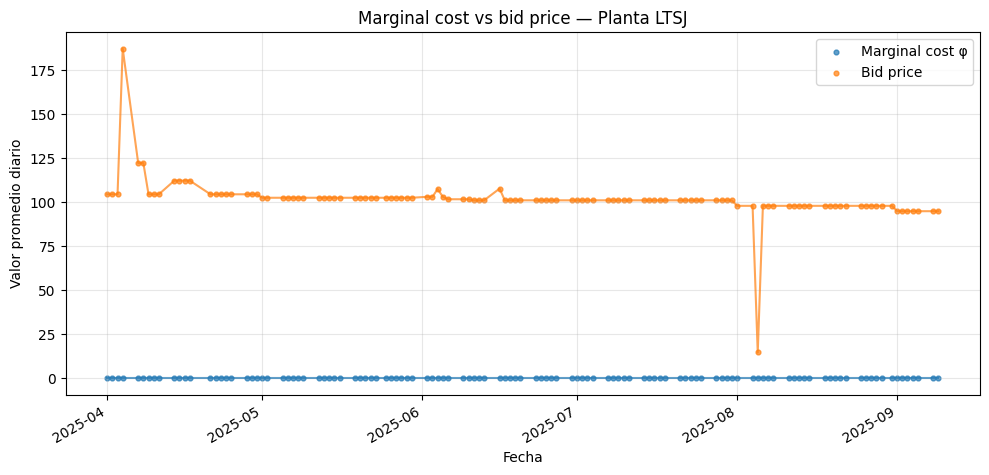

../results/fechas_117/phi_precio_LTSJ_20250401_to_20250909_M20.png


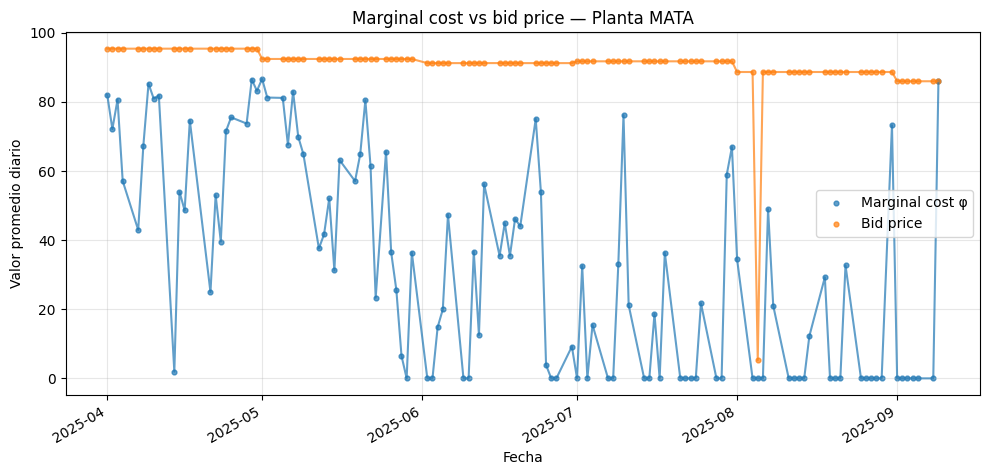

../results/fechas_117/phi_precio_MATA_20250401_to_20250909_M20.png


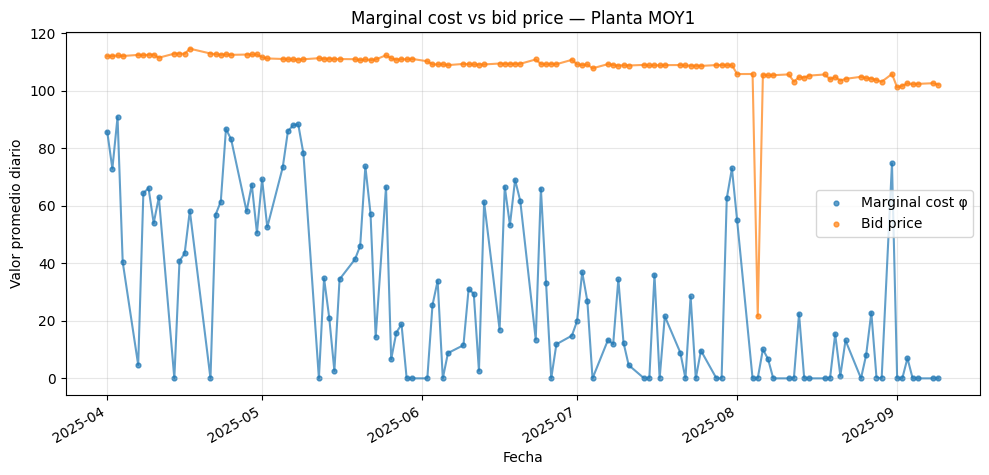

../results/fechas_117/phi_precio_MOY1_20250401_to_20250909_M20.png


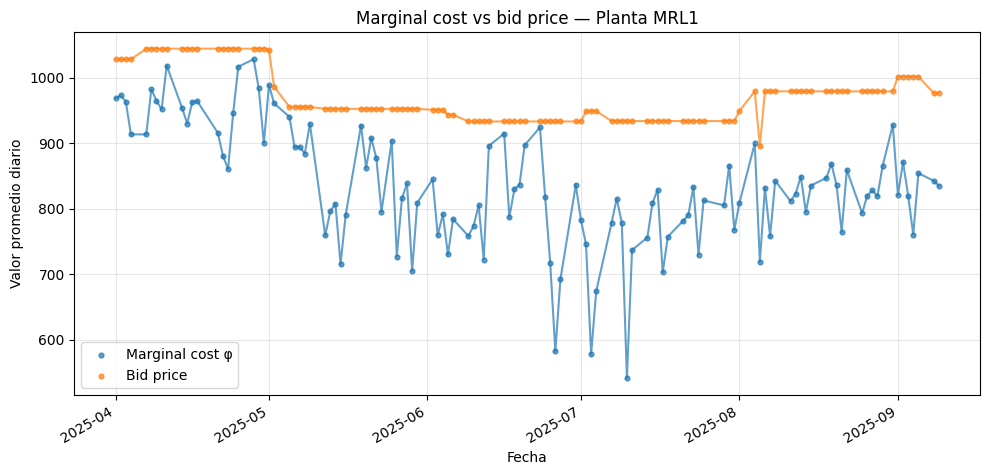

../results/fechas_117/phi_precio_MRL1_20250401_to_20250909_M20.png


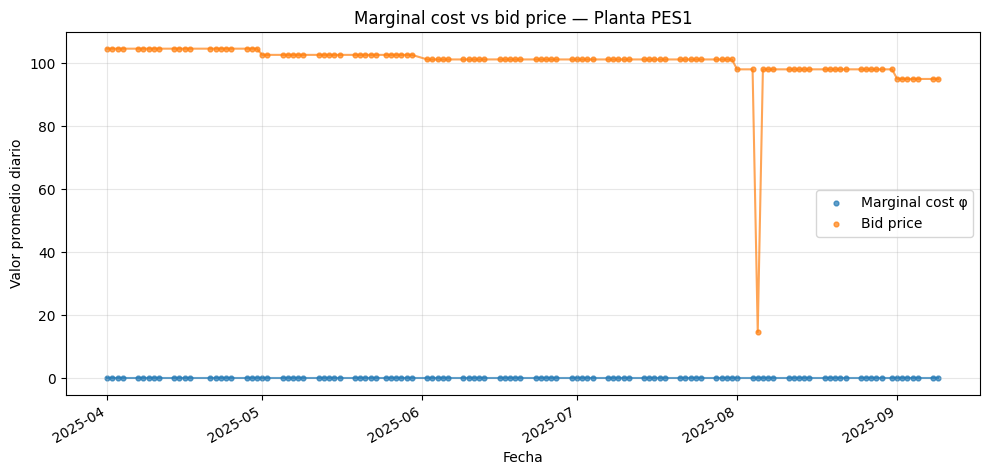

../results/fechas_117/phi_precio_PES1_20250401_to_20250909_M20.png


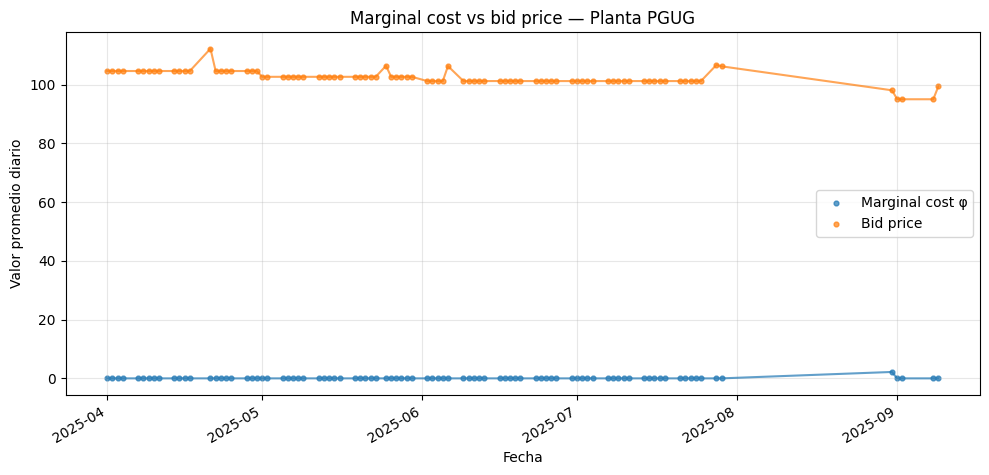

../results/fechas_117/phi_precio_PGUG_20250401_to_20250909_M20.png


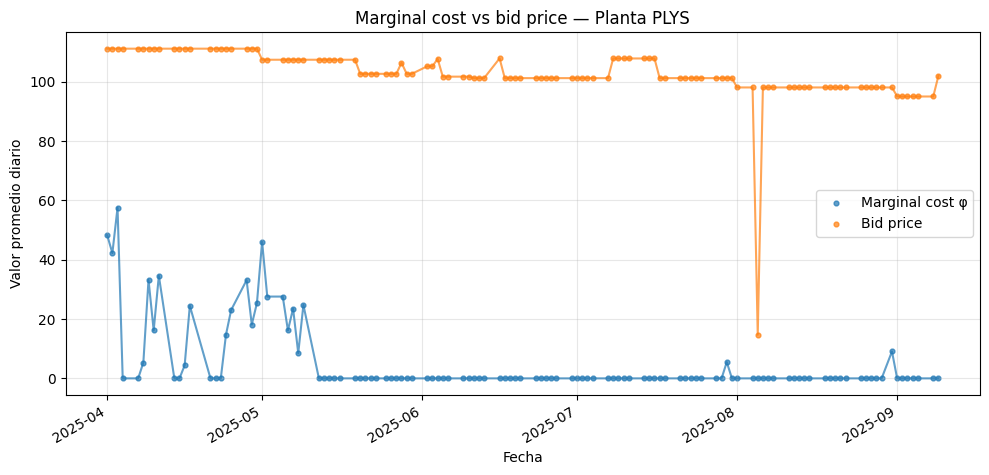

../results/fechas_117/phi_precio_PLYS_20250401_to_20250909_M20.png


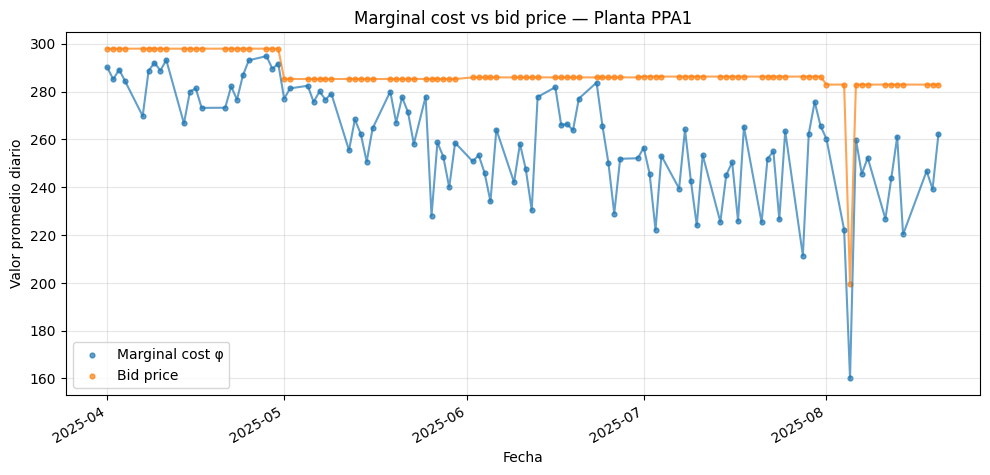

../results/fechas_117/phi_precio_PPA1_20250401_to_20250820_M20.png


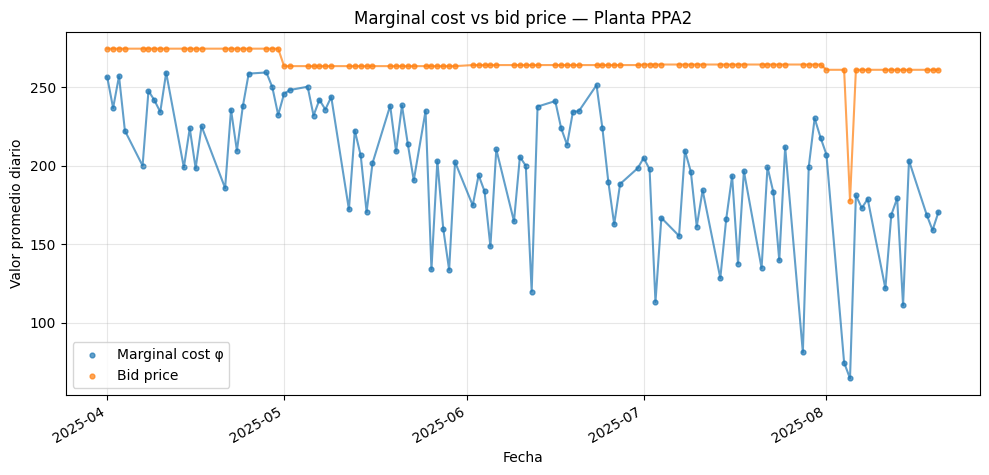

../results/fechas_117/phi_precio_PPA2_20250401_to_20250820_M20.png


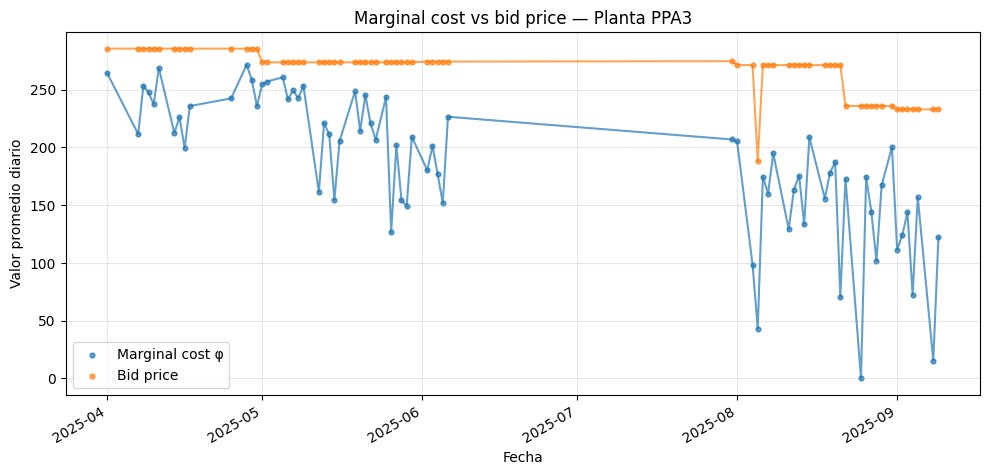

../results/fechas_117/phi_precio_PPA3_20250401_to_20250909_M20.png


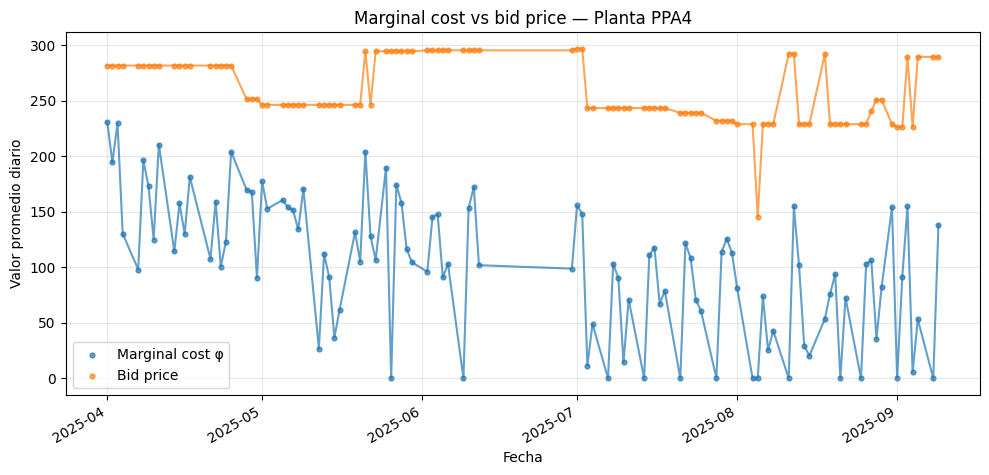

../results/fechas_117/phi_precio_PPA4_20250401_to_20250909_M20.png


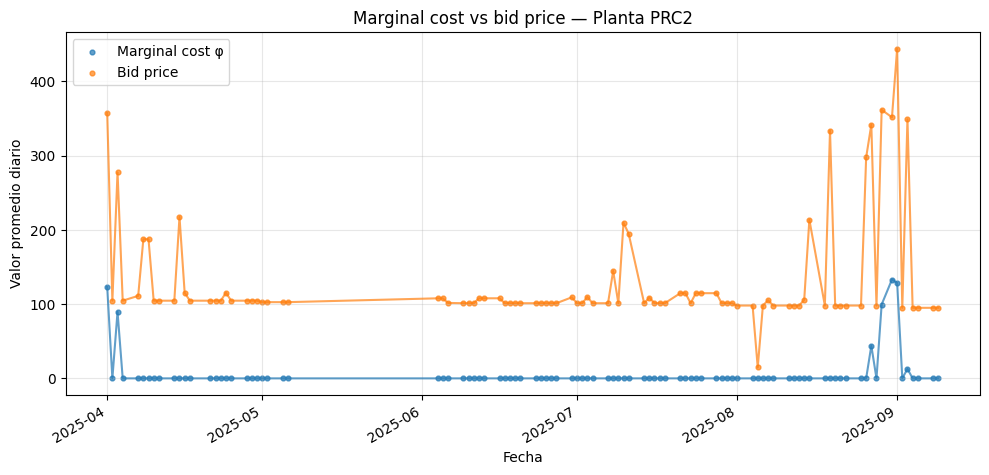

../results/fechas_117/phi_precio_PRC2_20250401_to_20250909_M20.png


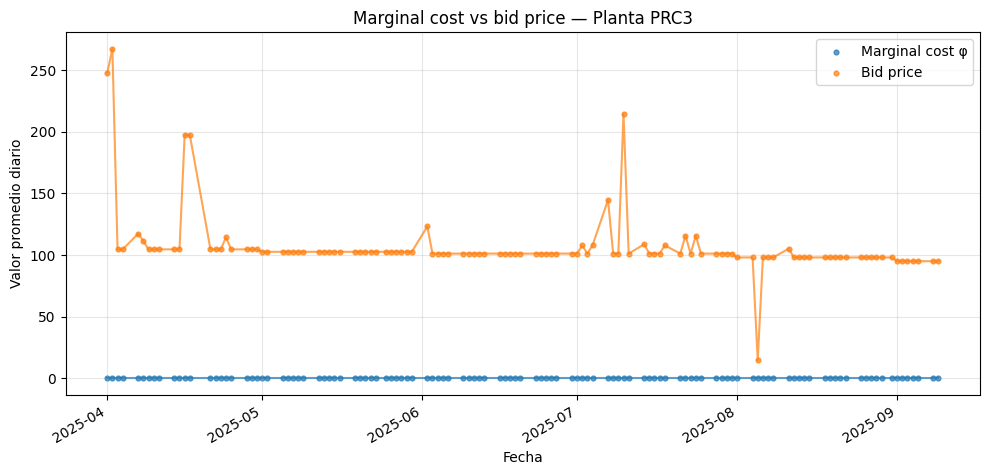

../results/fechas_117/phi_precio_PRC3_20250401_to_20250909_M20.png


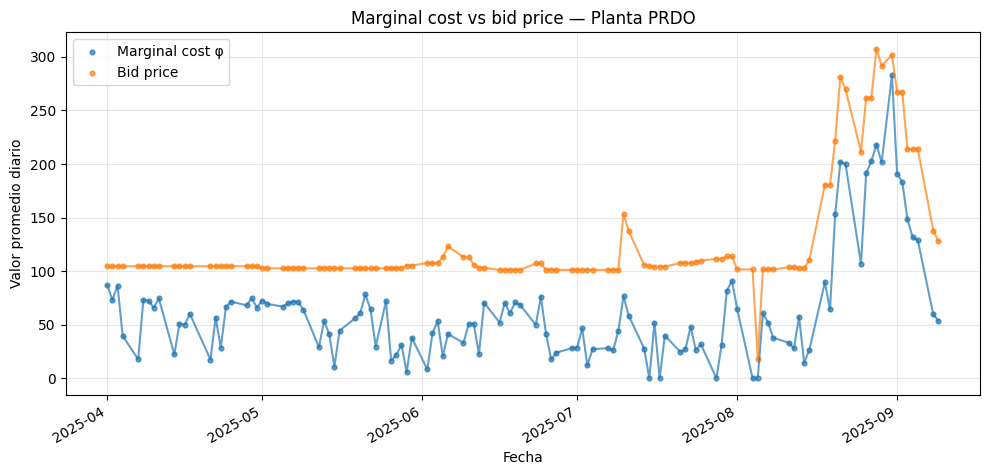

../results/fechas_117/phi_precio_PRDO_20250401_to_20250909_M20.png


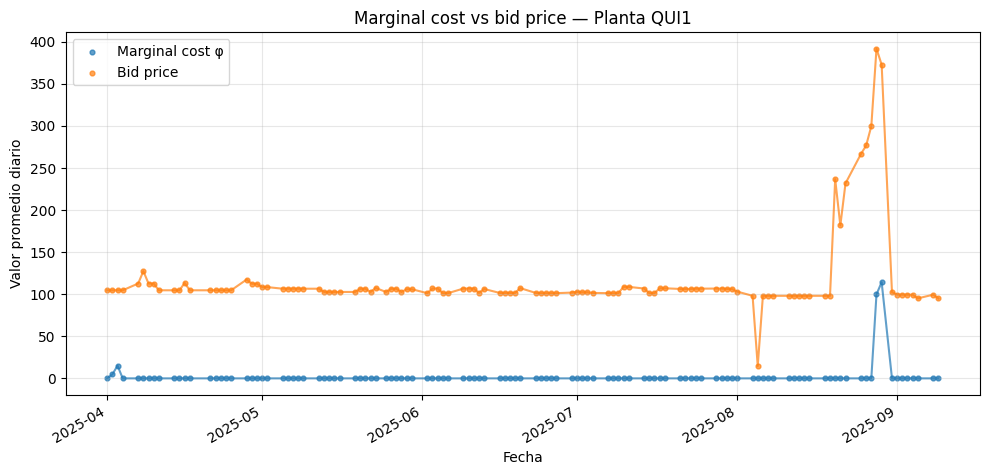

../results/fechas_117/phi_precio_QUI1_20250401_to_20250909_M20.png


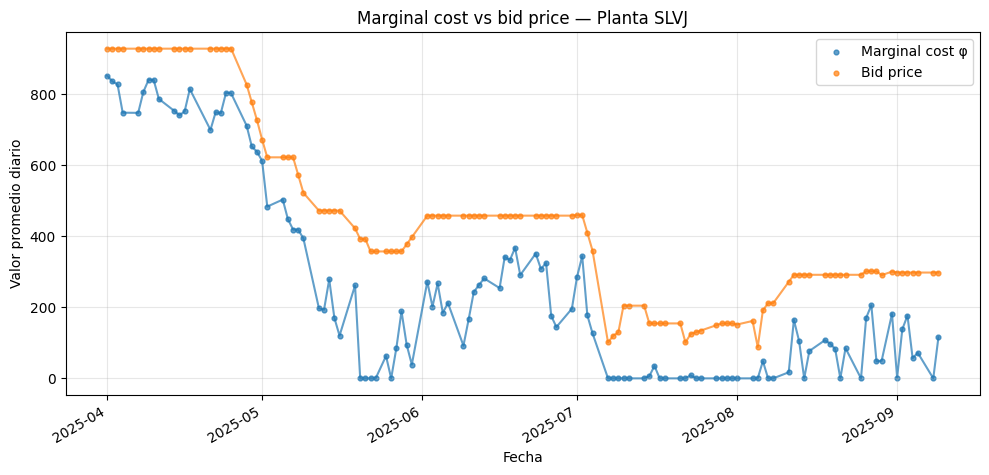

../results/fechas_117/phi_precio_SLVJ_20250401_to_20250909_M20.png


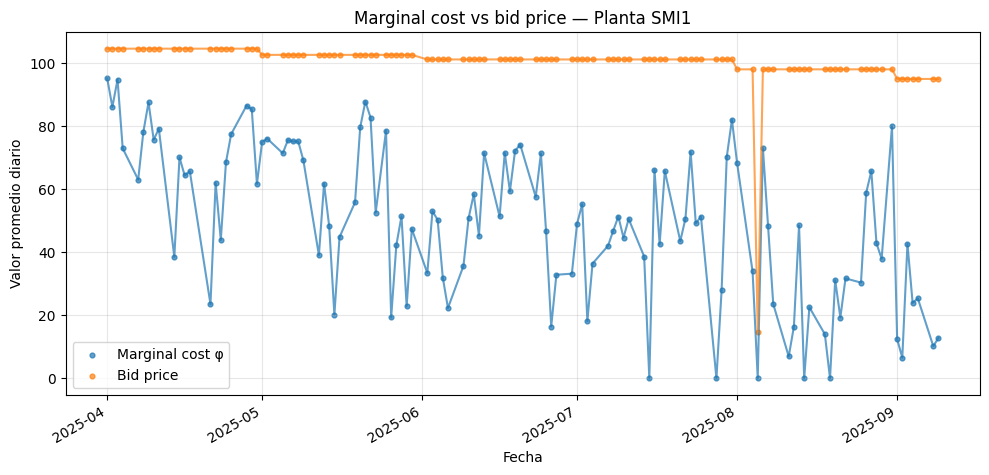

../results/fechas_117/phi_precio_SMI1_20250401_to_20250909_M20.png


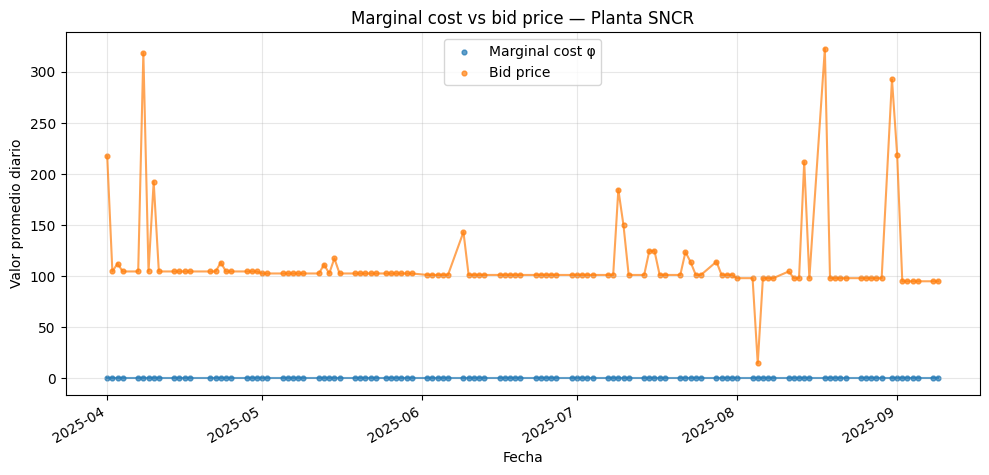

../results/fechas_117/phi_precio_SNCR_20250401_to_20250909_M20.png


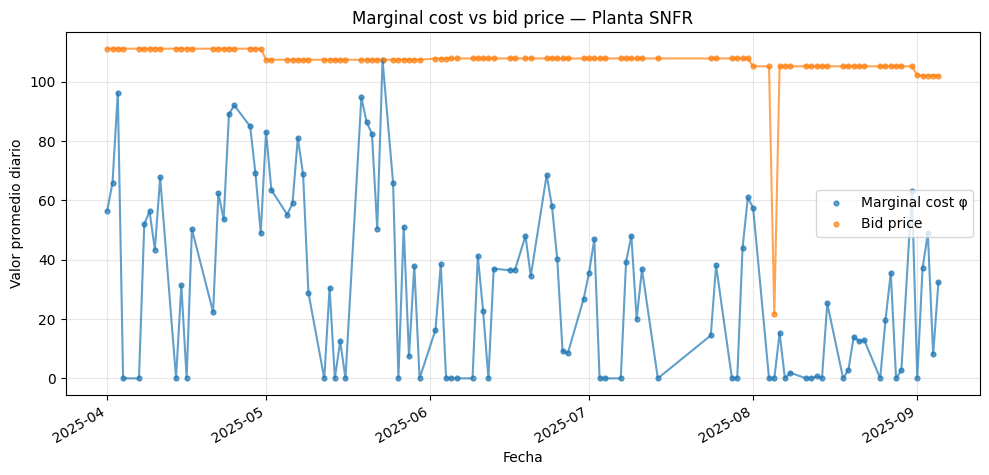

../results/fechas_117/phi_precio_SNFR_20250401_to_20250905_M20.png


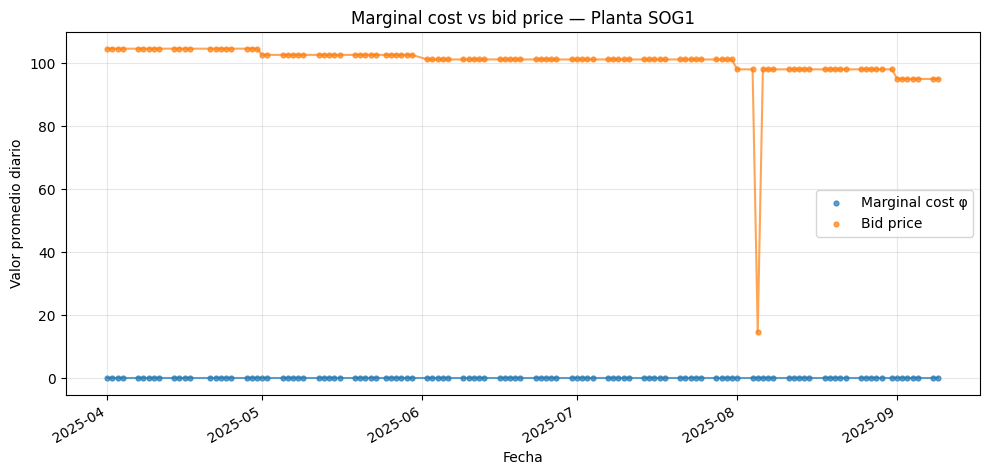

../results/fechas_117/phi_precio_SOG1_20250401_to_20250909_M20.png


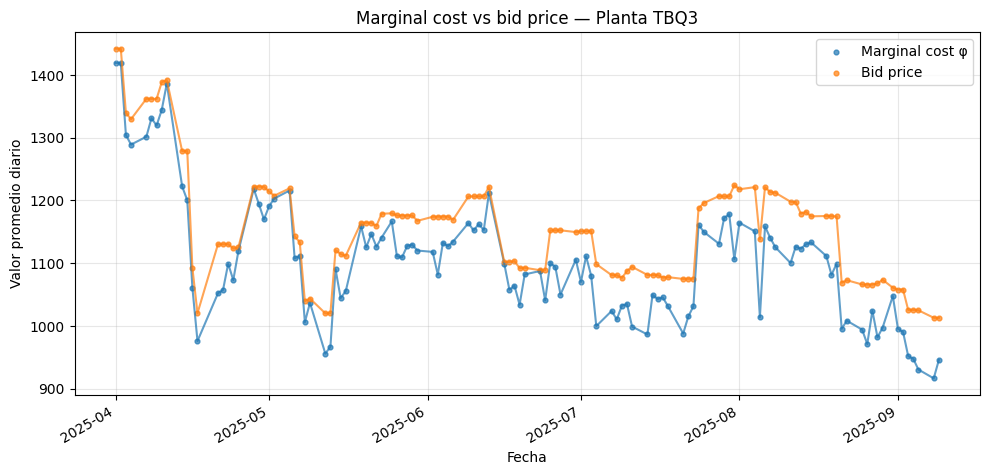

../results/fechas_117/phi_precio_TBQ3_20250401_to_20250909_M20.png


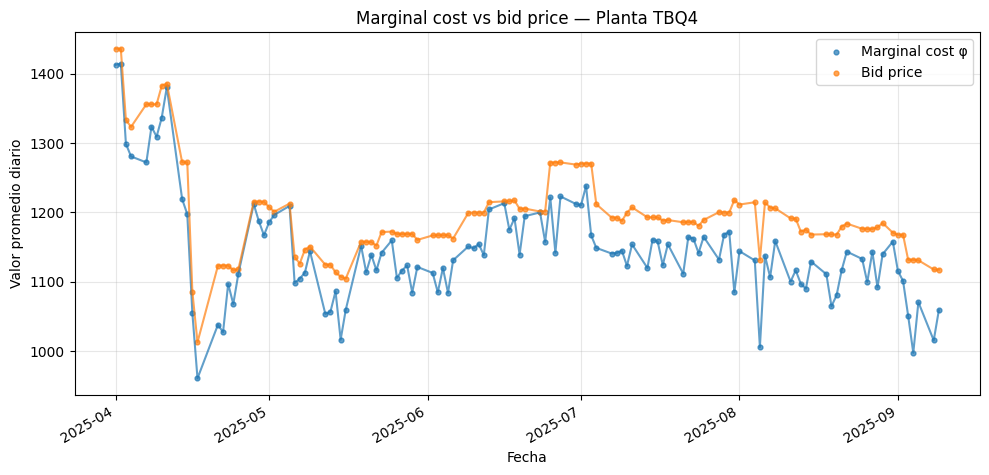

../results/fechas_117/phi_precio_TBQ4_20250401_to_20250909_M20.png


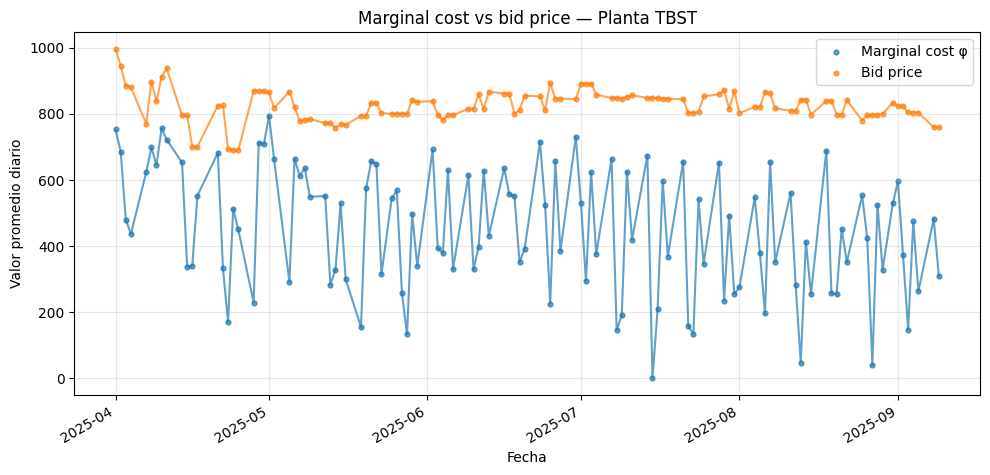

../results/fechas_117/phi_precio_TBST_20250401_to_20250909_M20.png


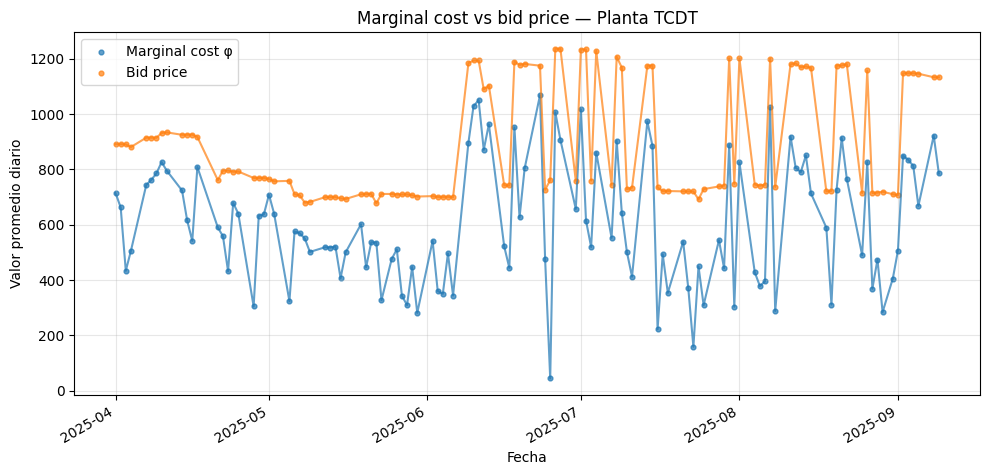

../results/fechas_117/phi_precio_TCDT_20250401_to_20250909_M20.png


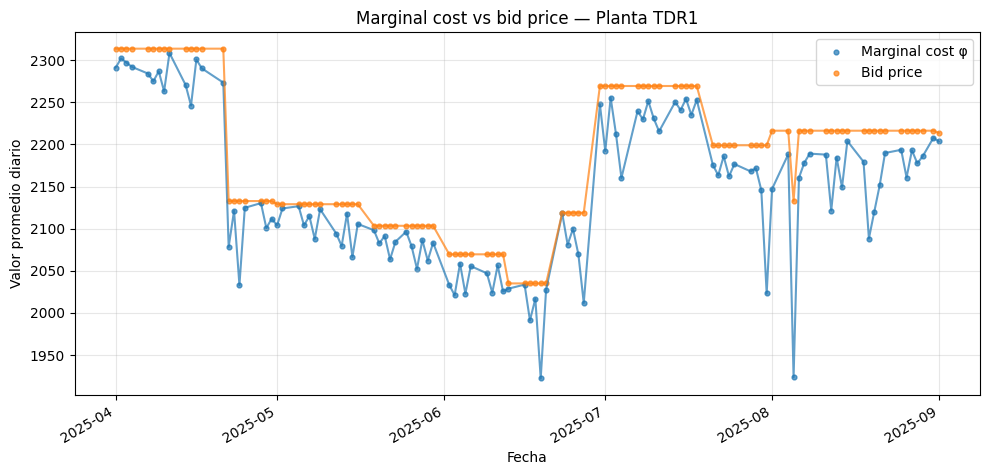

../results/fechas_117/phi_precio_TDR1_20250401_to_20250901_M20.png


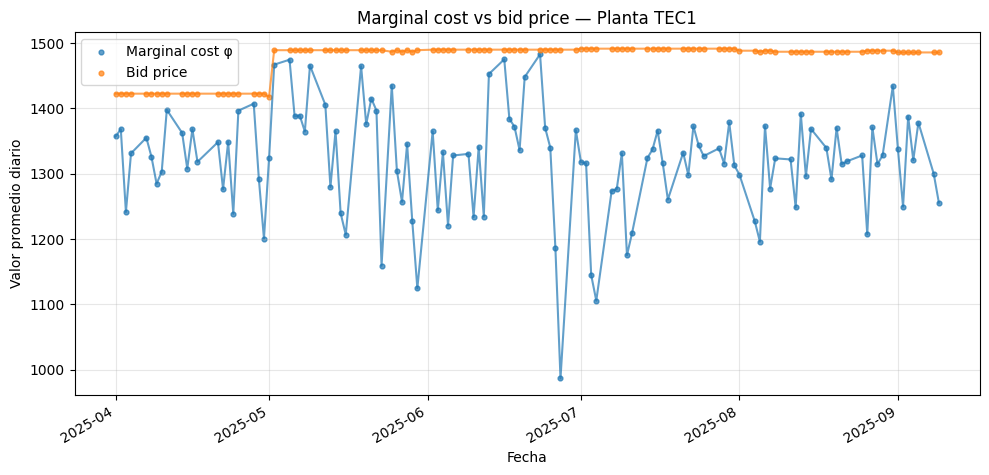

../results/fechas_117/phi_precio_TEC1_20250401_to_20250909_M20.png


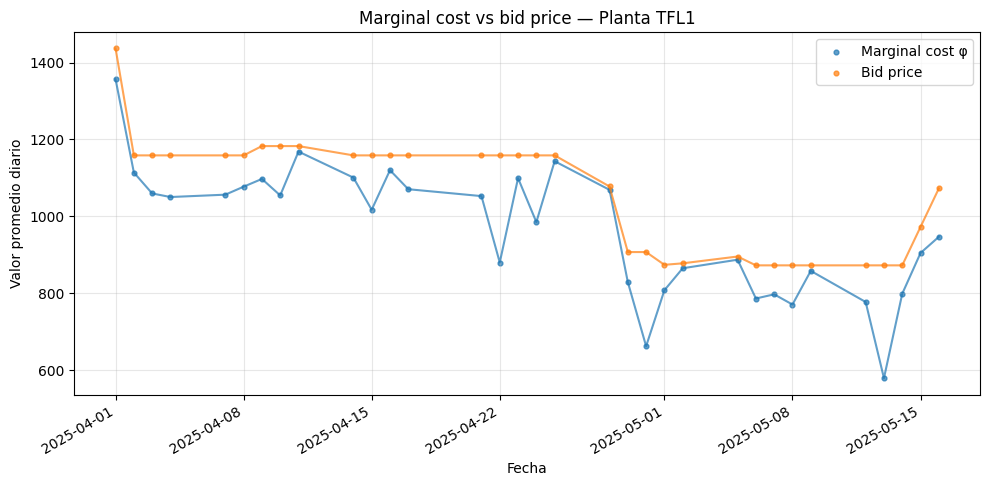

../results/fechas_117/phi_precio_TFL1_20250401_to_20250516_M20.png


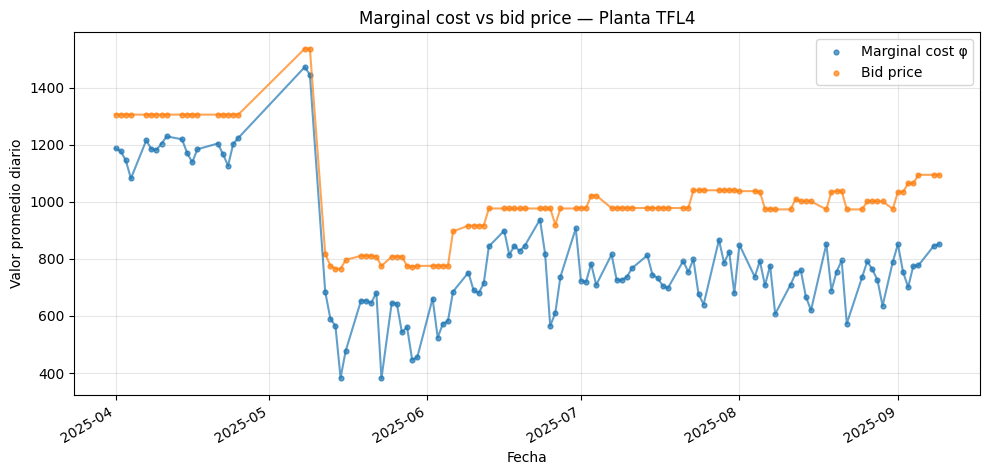

../results/fechas_117/phi_precio_TFL4_20250401_to_20250909_M20.png


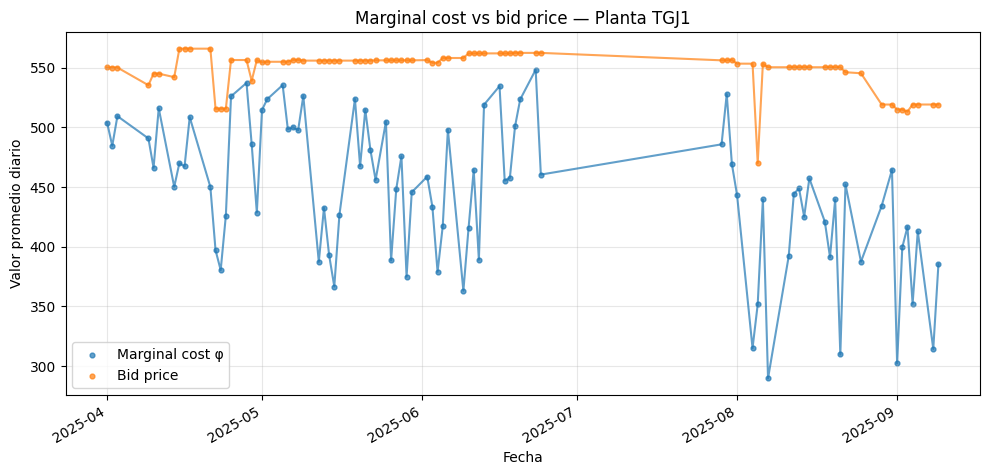

../results/fechas_117/phi_precio_TGJ1_20250401_to_20250909_M20.png


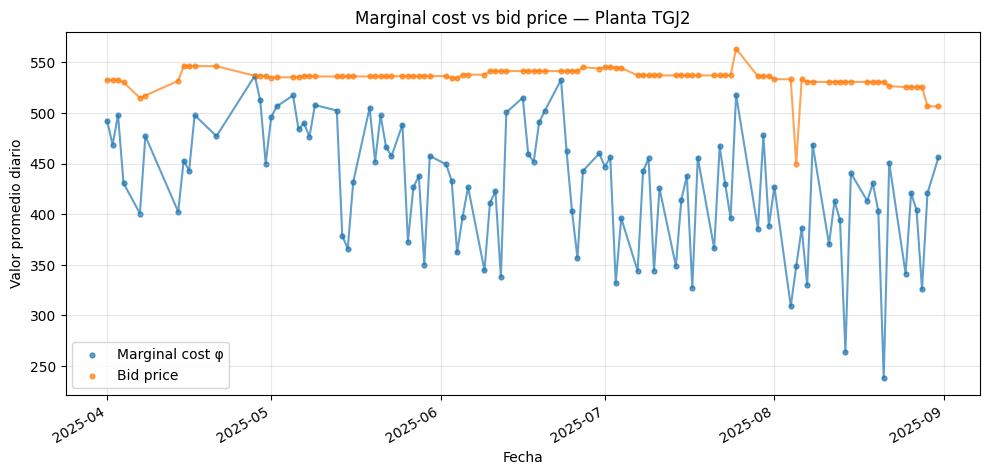

../results/fechas_117/phi_precio_TGJ2_20250401_to_20250831_M20.png


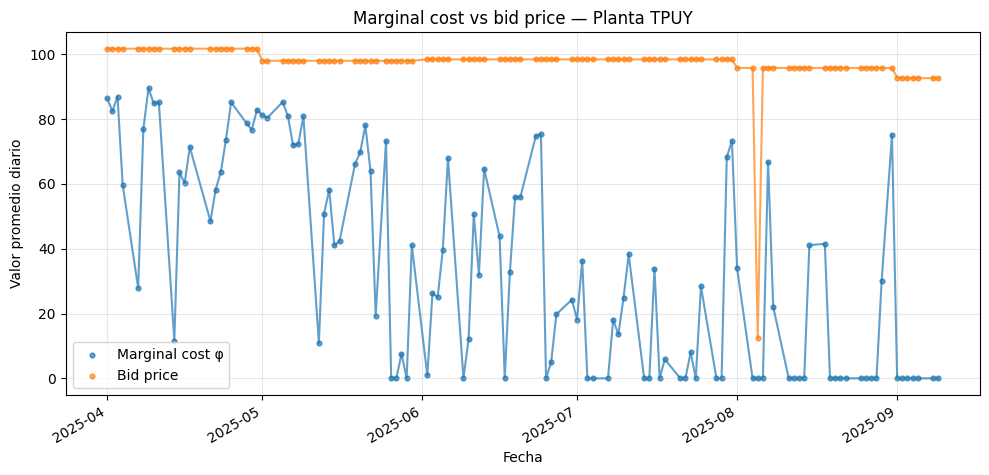

../results/fechas_117/phi_precio_TPUY_20250401_to_20250909_M20.png


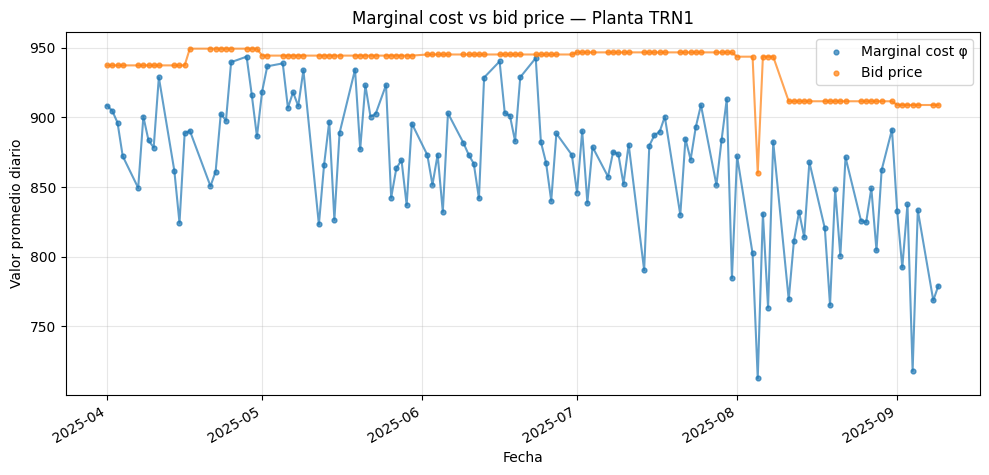

../results/fechas_117/phi_precio_TRN1_20250401_to_20250909_M20.png


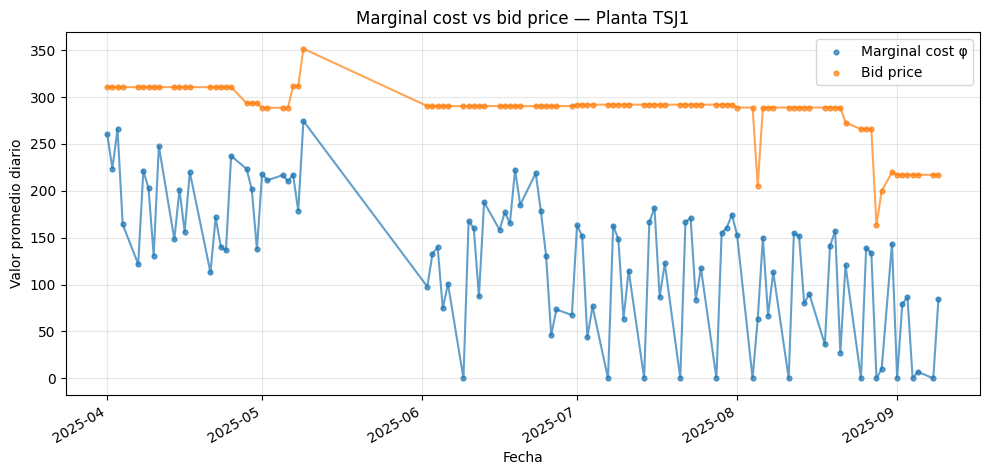

../results/fechas_117/phi_precio_TSJ1_20250401_to_20250909_M20.png


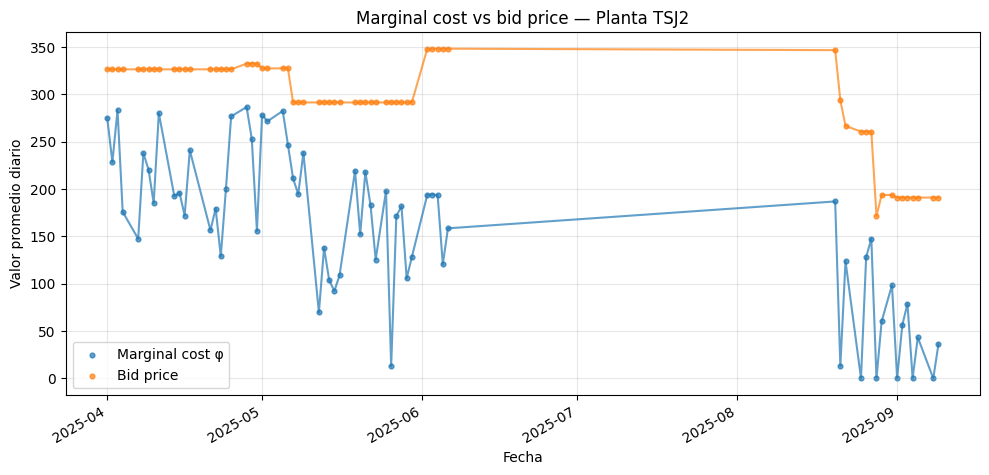

../results/fechas_117/phi_precio_TSJ2_20250401_to_20250909_M20.png


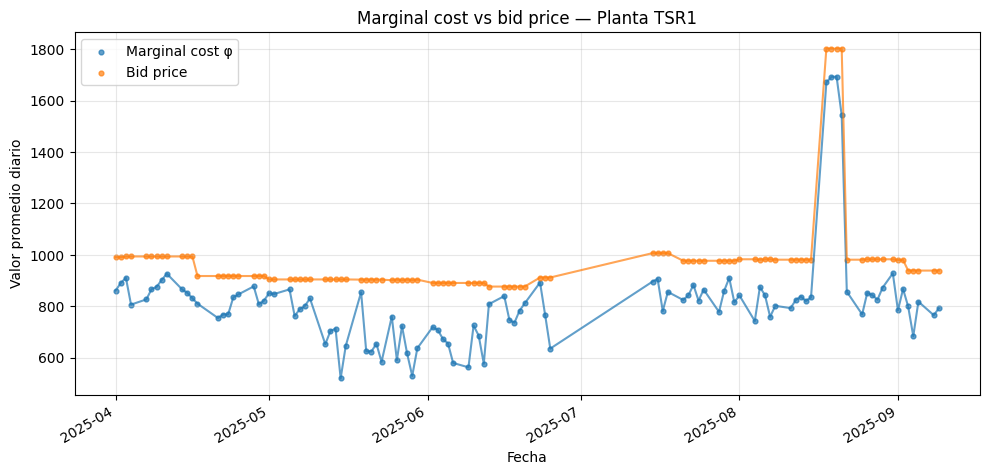

../results/fechas_117/phi_precio_TSR1_20250401_to_20250909_M20.png


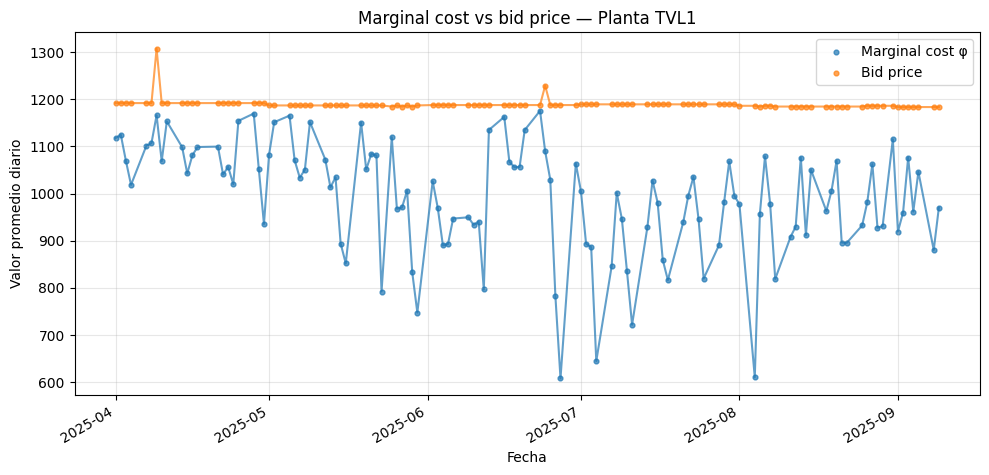

../results/fechas_117/phi_precio_TVL1_20250401_to_20250909_M20.png


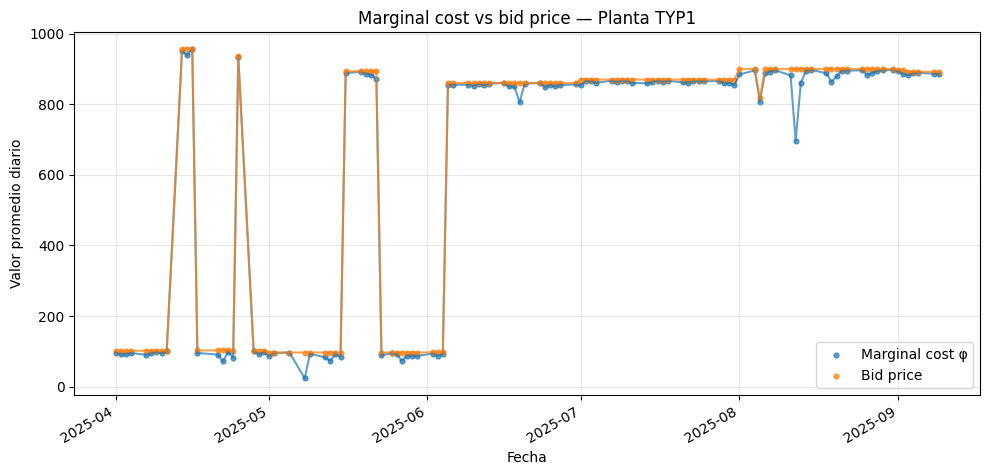

../results/fechas_117/phi_precio_TYP1_20250401_to_20250909_M20.png


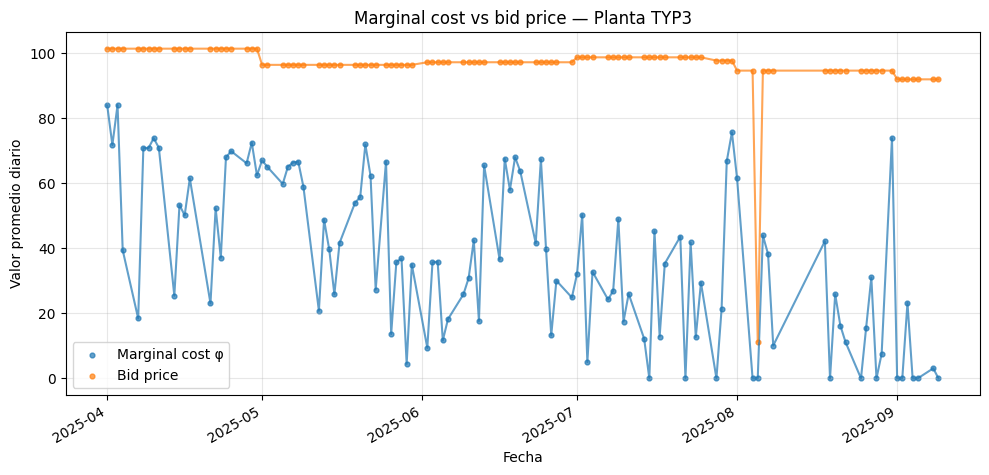

../results/fechas_117/phi_precio_TYP3_20250401_to_20250909_M20.png


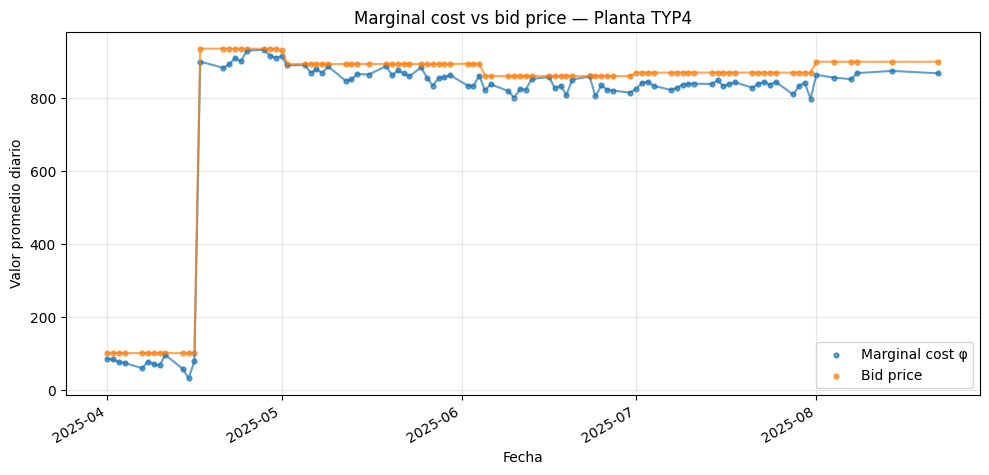

../results/fechas_117/phi_precio_TYP4_20250401_to_20250822_M20.png


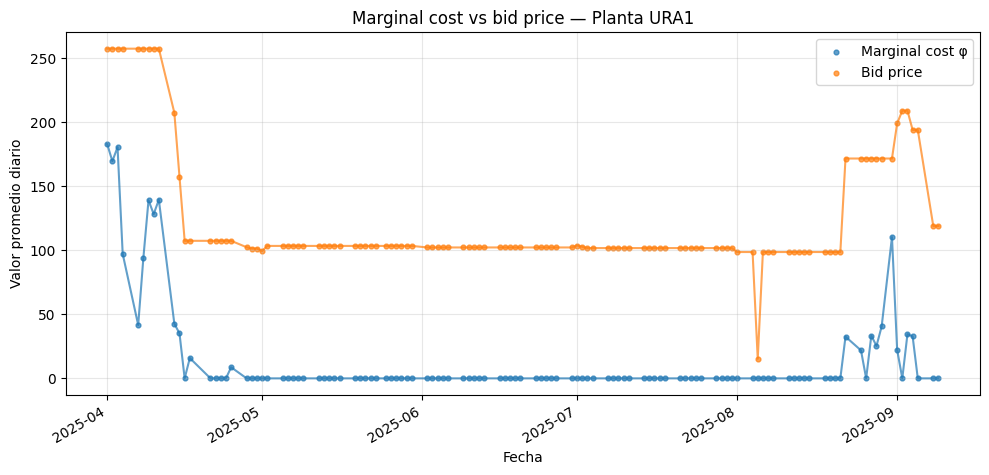

../results/fechas_117/phi_precio_URA1_20250401_to_20250909_M20.png


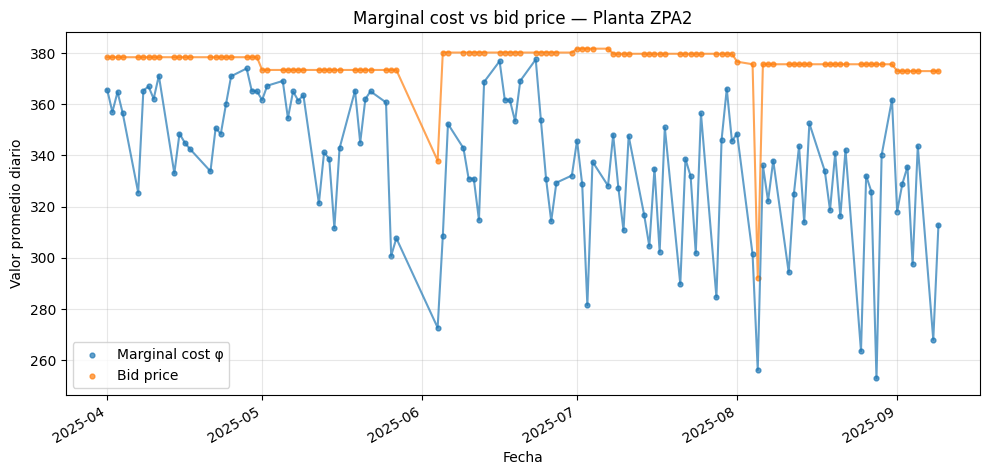

../results/fechas_117/phi_precio_ZPA2_20250401_to_20250909_M20.png


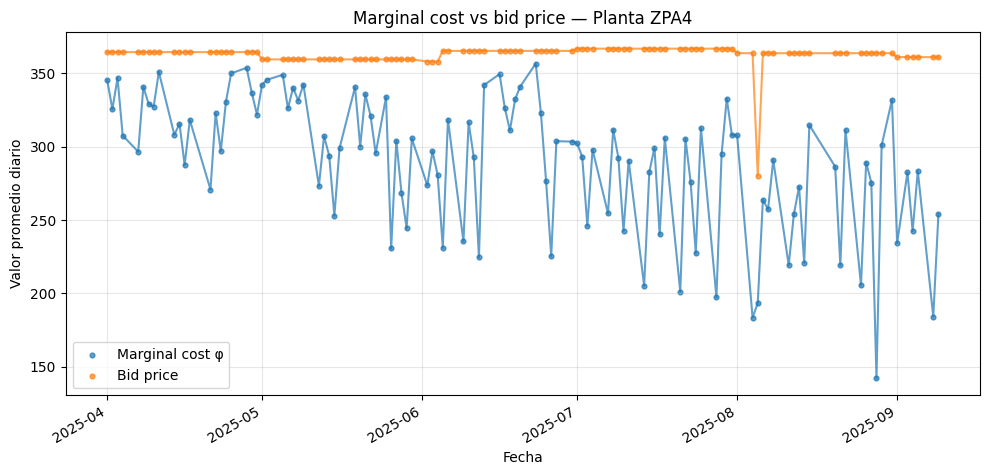

../results/fechas_117/phi_precio_ZPA4_20250401_to_20250909_M20.png


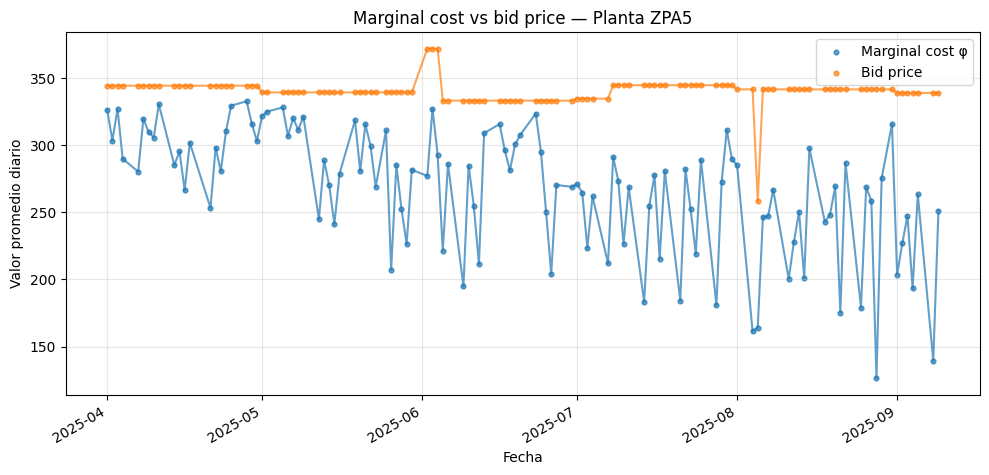

../results/fechas_117/phi_precio_ZPA5_20250401_to_20250909_M20.png


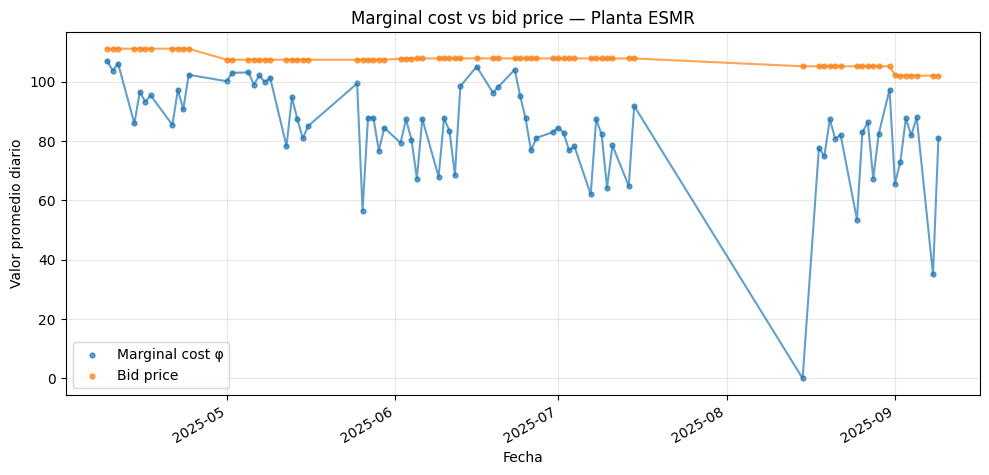

../results/fechas_117/phi_precio_ESMR_20250409_to_20250909_M20.png


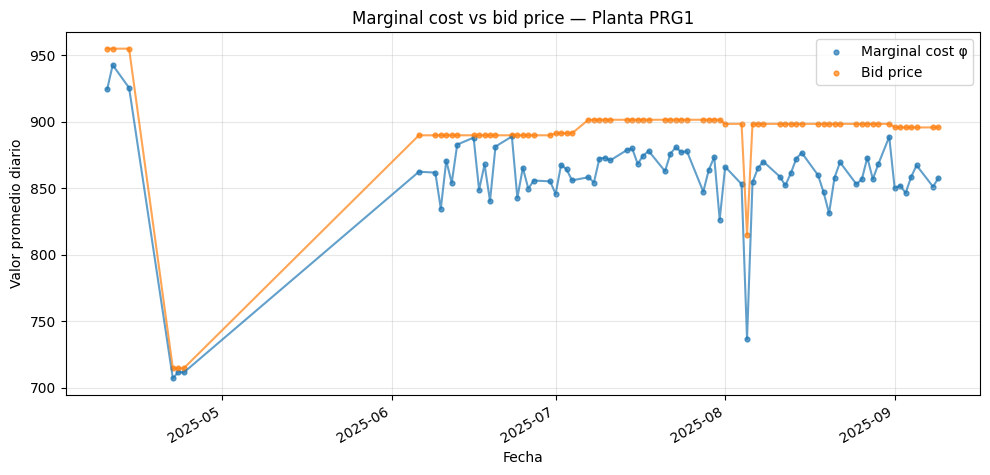

../results/fechas_117/phi_precio_PRG1_20250410_to_20250909_M20.png


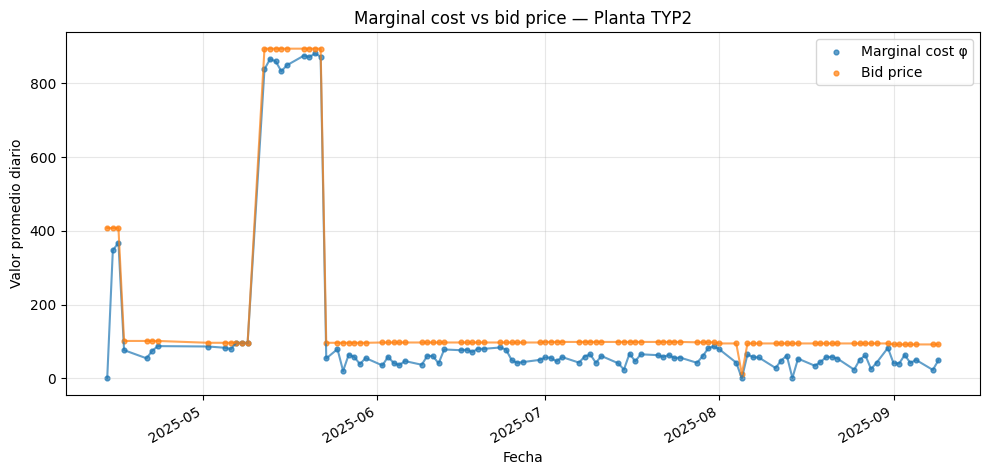

../results/fechas_117/phi_precio_TYP2_20250414_to_20250909_M20.png


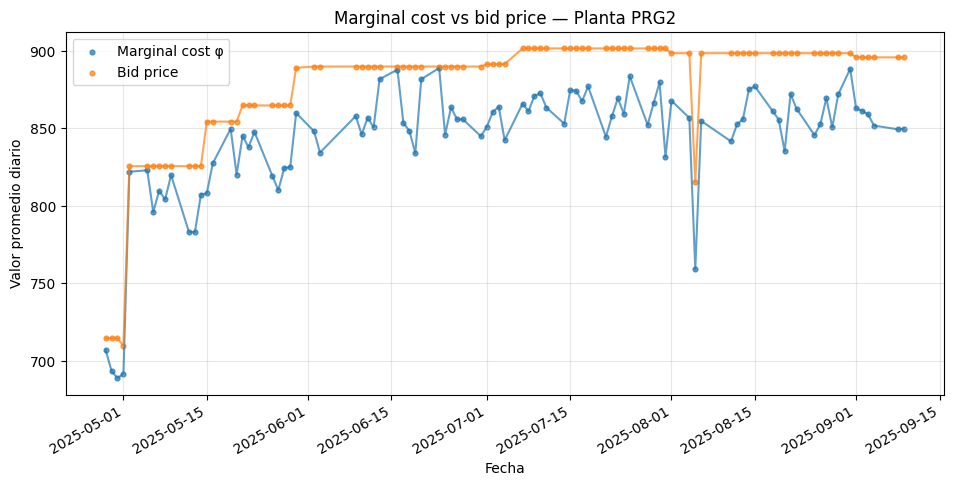

../results/fechas_117/phi_precio_PRG2_20250428_to_20250909_M20.png


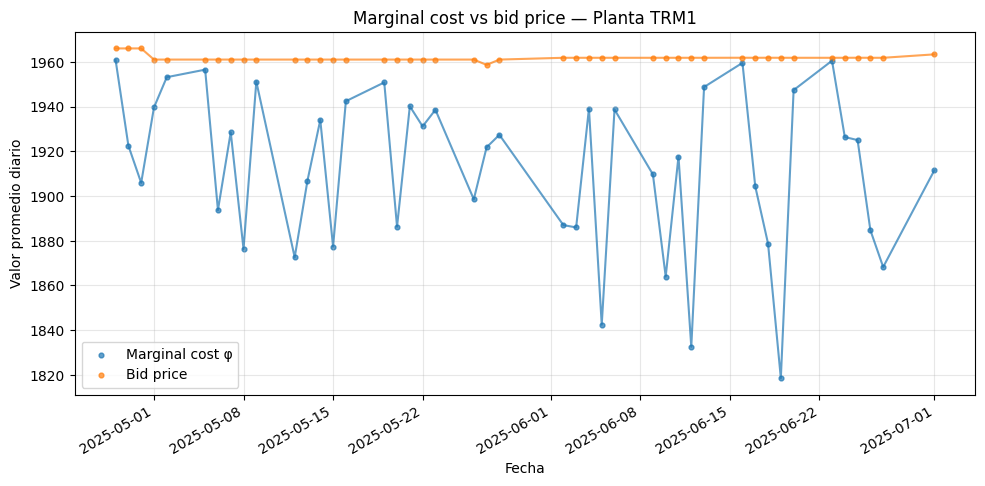

../results/fechas_117/phi_precio_TRM1_20250428_to_20250701_M20.png


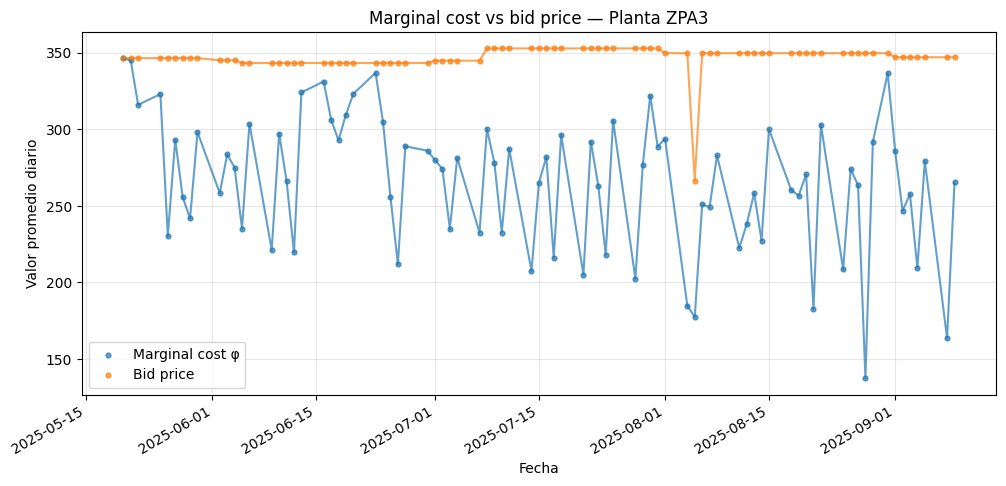

../results/fechas_117/phi_precio_ZPA3_20250520_to_20250909_M20.png


In [221]:
variable = 'phi'

df_grouped = df_grouped.dropna(subset=['Fecha', 'CodigoPlanta', variable, 'precio_d'])

for planta in df_grouped['CodigoPlanta'].unique():

    df_planta = (
        df_grouped[df_grouped['CodigoPlanta'] == planta]
        .groupby('Fecha', as_index=False)[[variable, 'precio_d']]
        .mean()
        .sort_values('Fecha')
    )

    plt.figure(figsize=(10, 5))

    plt.plot(df_planta['Fecha'], df_planta[variable], alpha=0.7)
    plt.scatter(df_planta['Fecha'], df_planta[variable], s=12, alpha=0.7, label='Marginal cost φ')

    plt.plot(df_planta['Fecha'], df_planta['precio_d'], alpha=0.7)
    plt.scatter(df_planta['Fecha'], df_planta['precio_d'], s=12, alpha=0.7, label='Bid price')

    plt.xlabel("Fecha")
    plt.ylabel("Valor promedio diario")
    plt.title(f"Marginal cost vs bid price — Planta {planta}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()

    fecha_min_str = pd.to_datetime(df_planta['Fecha'].min()).strftime('%Y%m%d')
    fecha_max_str = pd.to_datetime(df_planta['Fecha'].max()).strftime('%Y%m%d')

    filename = f"{variable}_precio_{planta}_{fecha_min_str}_to_{fecha_max_str}_M{M}.png"
    filepath = os.path.join(sub_dir, filename)

    plt.savefig(filepath, dpi=300)
    plt.show()

    print(f"{filepath}")


In [222]:
df_grouped

Fecha CodigoPlanta   numerador   denominador  precio_d     phi_agg  \
0    2025-04-01         2QEK   120000.00 -63180.187366    113.37  108.864589   
1    2025-04-01         3DDT   861305.73 -33157.180533    107.37   73.801598   
2    2025-04-01         3ENA  4800000.00 -82282.458218    889.28  723.916433   
3    2025-04-01         3HF5   453773.97 -28667.935925    107.37   77.565072   
4    2025-04-01         3INX   275076.26 -27206.220316     97.37   77.961248   
...         ...          ...         ...           ...       ...         ...   
8087 2025-09-09         URA1  3096000.00 -11575.164763    118.94    6.959976   
8088 2025-09-09         ZPA2   468000.00  -7778.512512    372.94  305.805384   
8089 2025-09-09         ZPA3  1260000.00 -15419.687473    346.94  198.668968   
8090 2025-09-09         ZPA4  1280000.00 -11976.301401    360.94  200.584352   
8091 2025-09-09         ZPA5  1260000.00 -14355.057980    338.94  189.451097   

      ganador  available_q         phi  
0           1    120000.00  111.470670  
1           1    861305.73   81.393553  
2           0   4800000.00  830.944358  
3           1    453773.97   91.541376  
4           1    275076.26   87.259214  
...       ...          ...         ...  
8087        1   3096000.00    0.000000  
8088        1    864000.00  312.774255  
8089        1   1512000.00  265.226282  
8090        1   1536000.00  254.062262  
8091        1   1512000.00  251.166060  

[8092 rows x 9 columns]

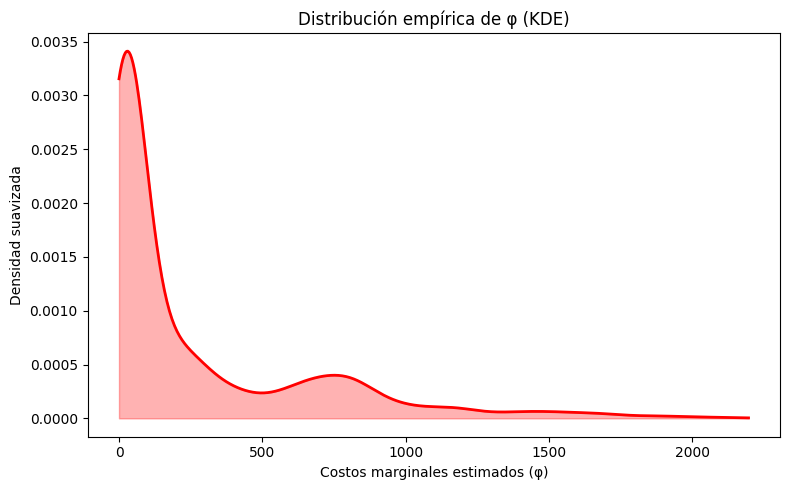

In [223]:

phi = pd.to_numeric(df_grouped['phi_agg'], errors='coerce').dropna()

# Calcular densidad KDE
kde = gaussian_kde(phi)
x_vals = np.linspace(phi.min(), phi.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, color="red", linewidth=2)
plt.fill_between(x_vals, y_vals, color="red", alpha=0.3)
plt.xlabel("Costos marginales estimados (φ)")
plt.ylabel("Densidad suavizada")
plt.title("Distribución empírica de φ (KDE)")
plt.tight_layout()
plt.show()


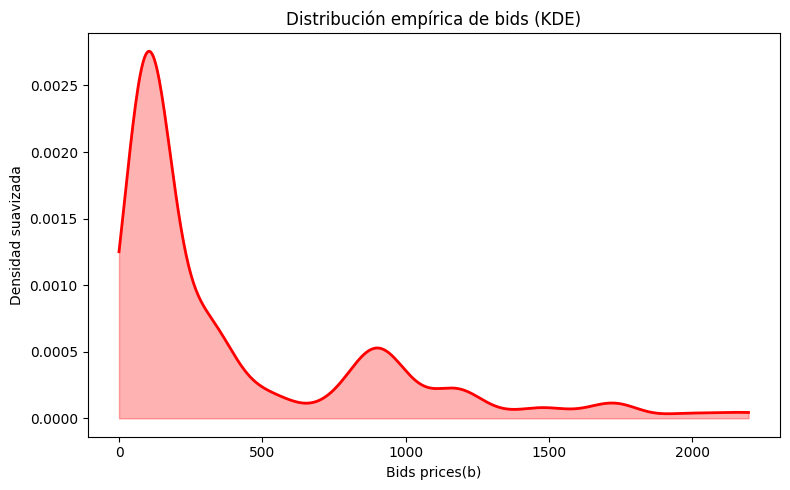

In [224]:
bids = pd.to_numeric(df_grouped['precio_d'], errors='coerce').dropna()

# Calcular densidad KDE
kde = gaussian_kde(bids)
x_vals = np.linspace(phi.min(), phi.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, color="red", linewidth=2)
plt.fill_between(x_vals, y_vals, color="red", alpha=0.3)
plt.xlabel("Bids prices(b)")
plt.ylabel("Densidad suavizada")
plt.title("Distribución empírica de bids (KDE)")
plt.tight_layout()
plt.show()


### Más markup - la grandes

In [225]:
df_result[df_result['CodigoPlanta'].isin(['GVIO', 'PES1', 'SNCR'])]
#PES1 es ituango, GVIO es guavio, SNCR es san carlos

FechaHora CodigoPlanta  precio   cantidad  cantidad_pos  \
13     2025-04-01 00:00:00         PES1  104.61  1200000.0     1200000.0   
22     2025-04-01 00:00:00         GVIO  162.37   944000.0      944000.0   
25     2025-04-01 00:00:00         SNCR  217.37  1085000.0     1085000.0   
72     2025-04-01 01:00:00         PES1  104.61  1200000.0     1200000.0   
81     2025-04-01 01:00:00         GVIO  162.37   944000.0      944000.0   
...                    ...          ...     ...        ...           ...   
176087 2025-09-09 22:00:00         GVIO   95.00  1250000.0     1250000.0   
176090 2025-09-09 22:00:00         SNCR   95.00  1085000.0     1085000.0   
176142 2025-09-09 23:00:00         PES1   95.00  1140000.0     1140000.0   
176144 2025-09-09 23:00:00         GVIO   95.00  1250000.0     1250000.0   
176147 2025-09-09 23:00:00         SNCR   95.00  1085000.0     1085000.0   

             Fecha  cluster  gamma_thumb      EQpos         EdQb  \
13      2025-04-01       10    25.654511  1200000.0 -1999.733168   
22      2025-04-01       10    24.946481   944000.0 -1946.877108   
25      2025-04-01       10    24.943955  1085000.0 -1884.845962   
72      2025-04-01       10    25.654511  1200000.0 -2000.958197   
81      2025-04-01       10    24.946481   944000.0 -2046.751462   
...            ...      ...          ...        ...          ...   
176087  2025-09-09       12    24.946481  1250000.0 -2026.834065   
176090  2025-09-09       12    24.943955  1085000.0 -1987.966382   
176142  2025-09-09       12    25.654511  1140000.0 -2035.569106   
176144  2025-09-09       12    24.946481  1250000.0 -2036.261569   
176147  2025-09-09       12    24.943955  1085000.0 -1995.507533   

        daily_eq_demand  ganador  cumulative_qty Tipo Generación  hour  \
13              8634480        1      3776899.29      HIDRAULICA     0   
22              8634480        1      6767899.29      HIDRAULICA     0   
25              8634480        1      8508899.29      HIDRAULICA     0   
72              8343930        1      3776445.48      HIDRAULICA     1   
81              8343930        1      6767445.48      HIDRAULICA     1   
...                 ...      ...             ...             ...   ...   
176087         10420020        1      3508000.00      HIDRAULICA    22   
176090         10420020        1      5399000.00      HIDRAULICA    22   
176142          9877640        1      1858000.00      HIDRAULICA    23   
176144          9877640        1      3508000.00      HIDRAULICA    23   
176147          9877640        1      5399000.00      HIDRAULICA    23   

        ratio_prueba  phi_h  
13       -600.080060    0.0  
22       -484.879090    0.0  
25       -575.643857    0.0  
72       -599.712679    0.0  
81       -461.218676    0.0  
...              ...    ...  
176087   -616.725376    0.0  
176090   -545.783877    0.0  
176142   -560.039940    0.0  
176144   -613.870054    0.0  
176147   -543.721325    0.0  

[8410 rows x 17 columns]

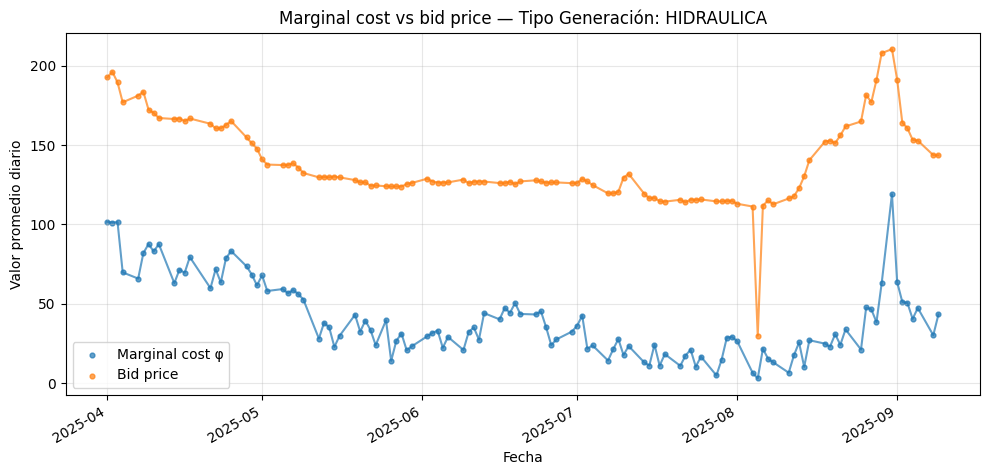

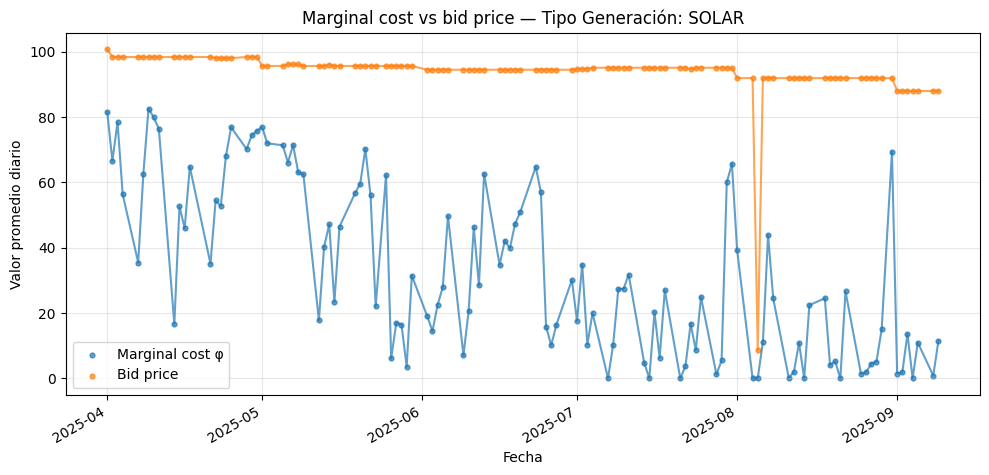

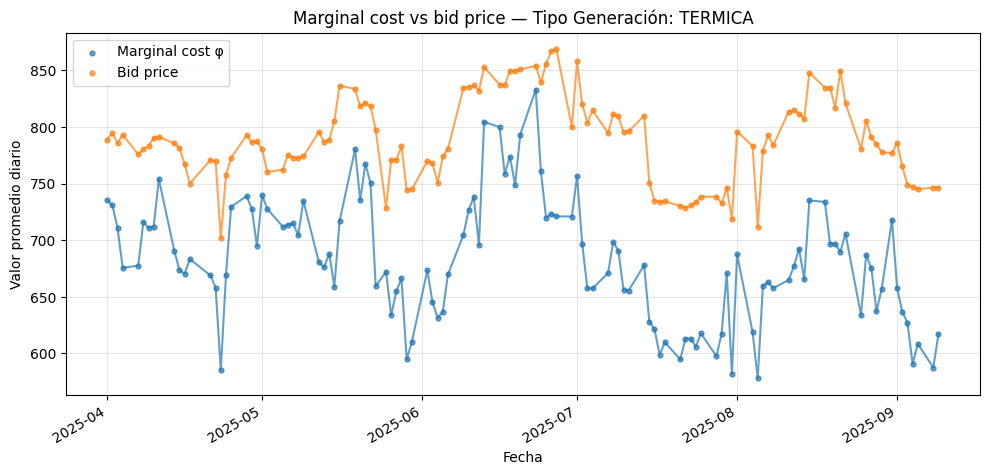

In [226]:
import matplotlib.pyplot as plt
import os
import pandas as pd

variable = 'phi'

for tipo in df_merged['Tipo Generación'].unique():

    df_tipo = (
        df_merged[df_merged['Tipo Generación'] == tipo]
        .groupby('Fecha', as_index=False)[[variable, 'precio_d']]
        .mean()
        .sort_values('Fecha')
    )

    # Fechas para el nombre del archivo
    fecha_min_str = pd.to_datetime(df_tipo['Fecha'].min()).strftime('%Y%m%d')
    fecha_max_str = pd.to_datetime(df_tipo['Fecha'].max()).strftime('%Y%m%d')

    filename = f"{variable}_precio_{tipo}_{fecha_min_str}_to_{fecha_max_str}_M{M}.png"
    filepath = os.path.join(sub_dir, filename)

    # --- Gráfica ---
    plt.figure(figsize=(10, 5))

    # φ
    plt.plot(df_tipo['Fecha'], df_tipo[variable], alpha=0.7)
    plt.scatter(df_tipo['Fecha'], df_tipo[variable], s=12, alpha=0.7, label='Marginal cost φ')

    # precio_d
    plt.plot(df_tipo['Fecha'], df_tipo['precio_d'], alpha=0.7)
    plt.scatter(df_tipo['Fecha'], df_tipo['precio_d'], s=12, alpha=0.7, label='Bid price')

    plt.xlabel("Fecha")
    plt.ylabel("Valor promedio diario")
    plt.title(f"Marginal cost vs bid price — Tipo Generación: {tipo}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()

    # Guardar y mostrar
    plt.savefig(filepath, dpi=300)
    plt.show()


In [227]:
df_merged['abs_markup'] =abs(df_merged['numerador'] /df_merged['denominador'])

In [228]:
import pandas as pd
import numpy as np

variables = ['phi', 'precio_d', 'abs_markup']

percentiles = [0.50]  # Solo para p50
tabla_list = []

# Agrupación a nivel de tipo de planta
for tipo, df_tipo in df_merged.groupby('Tipo Generación'):

    for var in variables:

        desc = df_tipo[var].describe(percentiles=[0.5])

        fila = {
            'Tipo Generación': tipo,
            'Variable': var,
            'count': desc['count'],
            'mean': desc['mean'],
            'std': desc['std'],
            'min': desc['min'],
            'p50': desc['50%'],   # mediana
            'max': desc['max']
        }

        tabla_list.append(fila)

tabla_final = pd.DataFrame(tabla_list)

# Mostrar tabla final
tabla_final



Tipo Generación    Variable   count          mean           std        min  \
0      HIDRAULICA         phi  3388.0  4.005427e+01  1.130224e+02   0.000000   
1      HIDRAULICA    precio_d  3388.0  1.384778e+02  1.234508e+02   7.270000   
2      HIDRAULICA  abs_markup  3387.0  2.420078e+02  1.984758e+02   1.899330   
3           SOLAR         phi  1158.0  3.276846e+01  3.152579e+01   0.000000   
4           SOLAR    precio_d  1158.0  9.394534e+01  9.077378e+00   3.360000   
5           SOLAR  abs_markup  1157.0  8.608852e+01  7.315774e+01   2.665660   
6         TERMICA         phi  3546.0  6.836582e+02  5.415241e+02   0.000000   
7         TERMICA    precio_d  3546.0  7.890750e+02  5.285958e+02  11.270000   
8         TERMICA  abs_markup  3546.0  2.637064e+24  1.570327e+26   0.000004   

          p50           max  
0    0.000000  8.956037e+02  
1  102.640000  9.283700e+02  
2  206.206888  2.512235e+03  
3   26.234601  9.285634e+01  
4   95.370000  1.073700e+02  
5   68.687754  5.258248e+02  
6  633.377348  2.308659e+03  
7  837.865000  2.313830e+03  
8   72.203123  9.351029e+27

../results/fechas_117/20250401_to_20250909_M20_full.png


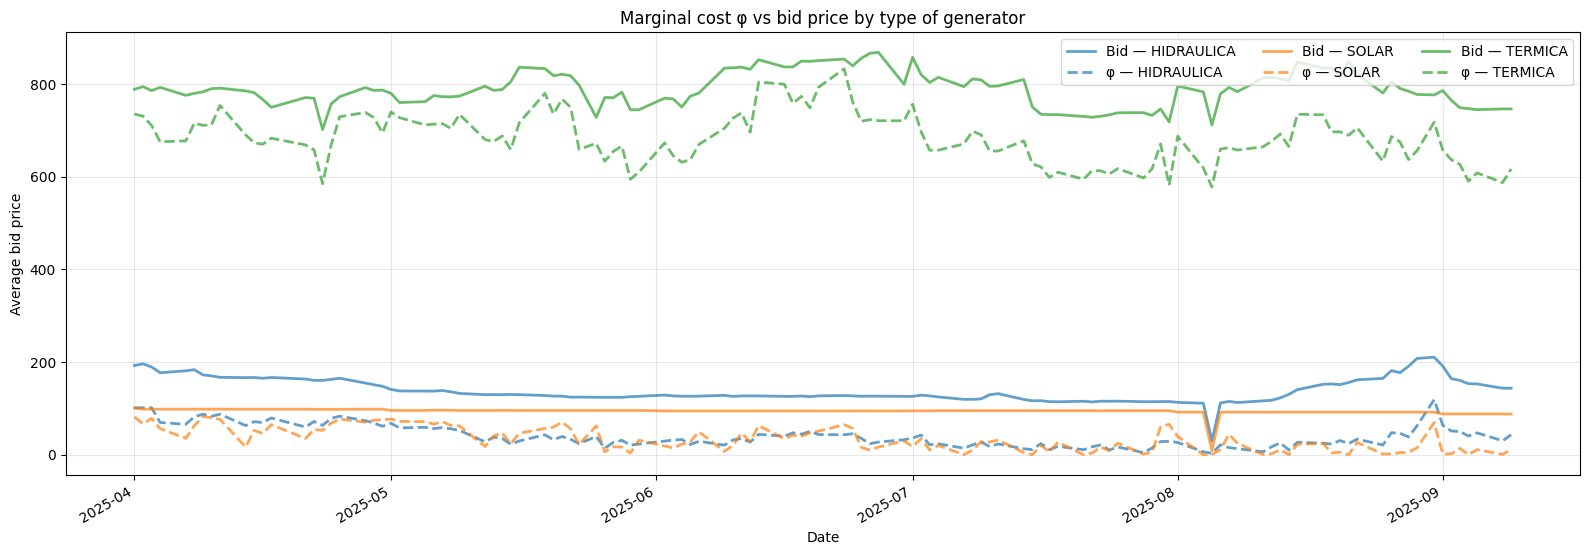

In [229]:
import matplotlib.pyplot as plt

variable = 'phi'

# Crear un color distinto por tipo de generación
tipos = df_merged['Tipo Generación'].unique()
colors = plt.cm.tab10(range(len(tipos)))  
color_dict = {tipo: colors[i] for i, tipo in enumerate(tipos)}

# Fechas para el nombre del archivo
fecha_min_str = pd.to_datetime(df_merged['Fecha'].min()).strftime('%Y%m%d')
fecha_max_str = pd.to_datetime(df_merged['Fecha'].max()).strftime('%Y%m%d')

filename = f"{fecha_min_str}_to_{fecha_max_str}_M{M}_full.png"
filepath = os.path.join(sub_dir, filename)

plt.figure(figsize=(16, 6))

# Graficar por tipo de generación
for tipo in tipos:

    df_tipo = (
        df_merged[df_merged['Tipo Generación'] == tipo]
        .groupby('Fecha', as_index=False)[[variable, 'precio_d']]
        .mean()
        .sort_values('Fecha')
    )

    c = color_dict[tipo]   # color asignado

    # --- φ (línea sólida) ---
     # --- precio_d (línea punteada con mismo color) ---
    plt.plot(
        df_tipo['Fecha'],
        df_tipo['precio_d'],
        alpha=0.7,
        linewidth=2,
        color=c,
        label=f"Bid — {tipo}"
    )
    plt.plot(
        df_tipo['Fecha'],
        df_tipo[variable],
        alpha=0.7,
        linestyle='--',
        linewidth=2,
        color=c,
        label=f"φ — {tipo}"
    )

   

# Configuración de la gráfica
plt.xlabel("Date")
plt.ylabel("Average bid price")
plt.title("Marginal cost φ vs bid price by type of generator")
plt.legend(loc='upper right', ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()

# Guardar y mostrar
plt.savefig(filepath, dpi=300, bbox_inches='tight')
print(filepath)
plt.show()



In [230]:
# solo winner
df_result_win = df_result[df_result['ganador'] == 1].copy()
df_grouped_win = (
    df_result_win.groupby(['Fecha', 'CodigoPlanta'], as_index=False)
      .agg(
          numerador=('EQpos', 'sum'),
          denominador=('EdQb', 'sum'),
          precio_d=('precio', 'max'),
          phi_agg=('phi_h', 'mean'), 
          ganador=('ganador', 'max')
      )
)


#encontrar formula de costo marginal:
# -------------------------------------------------------------------------
#
#      φ_{it} = b_{it} +
#               ( ∑_{h=0}^{23} E_{-it}[ Q_{ith} - pos_{ith} | s, p_{ht}=b_{it} ] )
#               ----------------------------------------------------------------
#               ( ∑_{h=0}^{23} E_{-it}[ ∂Q_{ith}/∂b_{it}    | s, p_{ht}=b_{it} ] )
#
# -------------------------------------------------------------------------

# Evitar divisiones por cero
df_grouped_win['phi'] = np.maximum(
    df_grouped_win['precio_d'] + np.where(
        df_grouped_win['denominador'] != 0,
        df_grouped_win['numerador'] / df_grouped_win['denominador'],
       0
    ),
    0
)
df_grouped_win['Fecha'] = pd.to_datetime(df_grouped_win['Fecha'])

df_merged_win = df_grouped_win.merge(
    df_desglose[["Código SIC", "Tipo Generación"]],
    left_on="CodigoPlanta",
    right_on="Código SIC",
    how="left"
)
df_merged_win = df_merged_win.drop(columns=["Código SIC"])

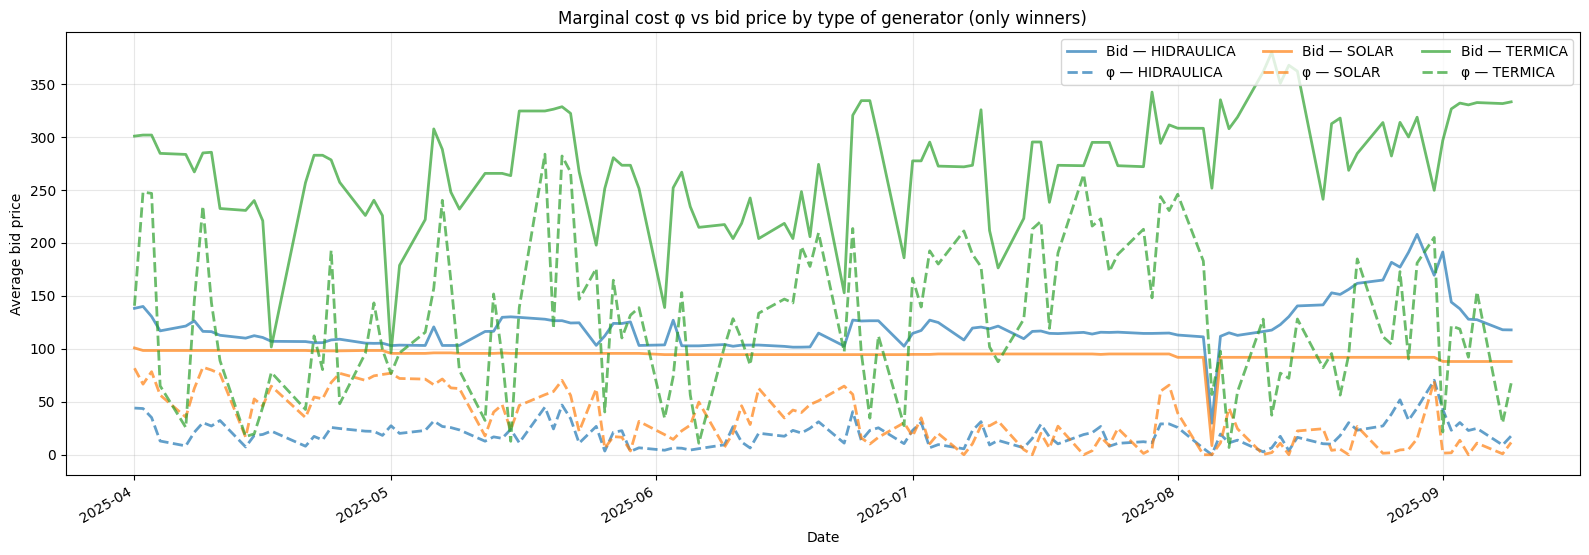

../results/fechas_117/20250401_to_20250909_M20_winners.png


In [231]:
import matplotlib.pyplot as plt

variable = 'phi'
filename = f"{fecha_min_str}_to_{fecha_max_str}_M{M}_winners.png"
filepath = os.path.join(sub_dir, filename)


# Crear un color distinto por tipo (usa el ciclo de colores de matplotlib)
tipos = df_merged_win['Tipo Generación'].unique()
colors = plt.cm.tab10(range(len(tipos)))  # 10 colores buenos y distintos

color_dict = {tipo: colors[i] for i, tipo in enumerate(tipos)}

plt.figure(figsize=(16, 6))

# Graficar por tipo de generación solo usando ganadores
for tipo in tipos:

    df_tipo = (
        df_merged_win[df_merged_win['Tipo Generación'] == tipo]
        .groupby('Fecha', as_index=False)[[variable, 'precio_d']]
        .mean()
        .sort_values('Fecha')
    )

    c = color_dict[tipo]   # color asignado

    # --- φ (línea sólida) ---
     # --- precio_d (línea punteada con mismo color) ---
    plt.plot(
        df_tipo['Fecha'],
        df_tipo['precio_d'],
        alpha=0.7,
        linewidth=2,
        color=c,
        label=f"Bid — {tipo}"
    )

    plt.plot(
        df_tipo['Fecha'],
        df_tipo[variable],
        alpha=0.7,
        linestyle='--',
        linewidth=2,
        color=c,
        label=f"φ — {tipo}"
    )

   
# Configuración de la gráfica
plt.xlabel("Date")
plt.ylabel("Average bid price")
plt.title("Marginal cost φ vs bid price by type of generator (only winners)")
plt.legend(loc='upper right', ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()

plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()
print(filepath)



In [232]:
df_grouped

Fecha CodigoPlanta   numerador   denominador  precio_d     phi_agg  \
0    2025-04-01         2QEK   120000.00 -63180.187366    113.37  108.864589   
1    2025-04-01         3DDT   861305.73 -33157.180533    107.37   73.801598   
2    2025-04-01         3ENA  4800000.00 -82282.458218    889.28  723.916433   
3    2025-04-01         3HF5   453773.97 -28667.935925    107.37   77.565072   
4    2025-04-01         3INX   275076.26 -27206.220316     97.37   77.961248   
...         ...          ...         ...           ...       ...         ...   
8087 2025-09-09         URA1  3096000.00 -11575.164763    118.94    6.959976   
8088 2025-09-09         ZPA2   468000.00  -7778.512512    372.94  305.805384   
8089 2025-09-09         ZPA3  1260000.00 -15419.687473    346.94  198.668968   
8090 2025-09-09         ZPA4  1280000.00 -11976.301401    360.94  200.584352   
8091 2025-09-09         ZPA5  1260000.00 -14355.057980    338.94  189.451097   

      ganador  available_q         phi  
0           1    120000.00  111.470670  
1           1    861305.73   81.393553  
2           0   4800000.00  830.944358  
3           1    453773.97   91.541376  
4           1    275076.26   87.259214  
...       ...          ...         ...  
8087        1   3096000.00    0.000000  
8088        1    864000.00  312.774255  
8089        1   1512000.00  265.226282  
8090        1   1536000.00  254.062262  
8091        1   1512000.00  251.166060  

[8092 rows x 9 columns]

In [233]:
import os
import matplotlib.pyplot as plt

variable = 'phi'

# Necesitamos conservar Tipo Generación
df_merged = df_merged .dropna(subset=['Fecha', 'CodigoPlanta', 'Tipo Generación', variable, 'precio_d'])

for planta in df_merged['CodigoPlanta'].unique():

    df_planta = (
        df_merged[df_merged['CodigoPlanta'] == planta]
        .groupby('Fecha', as_index=False)[[variable, 'precio_d']]
        .mean()
        .sort_values('Fecha')
    )

    # Tipo de generación de esta planta
    tipo = df_merged.loc[df_merged['CodigoPlanta'] == planta, 'Tipo Generación'].iloc[0]

    # Crear carpeta para este tipo
    tipo_dir = os.path.join(sub_dir, str(tipo))
    os.makedirs(tipo_dir, exist_ok=True)

    # Crear figura
    plt.figure(figsize=(10, 5))

    plt.plot(df_planta['Fecha'], df_planta[variable], alpha=0.7)
    plt.scatter(df_planta['Fecha'], df_planta[variable], s=12, alpha=0.7, label='Marginal cost φ')

    plt.plot(df_planta['Fecha'], df_planta['precio_d'], alpha=0.7)
    plt.scatter(df_planta['Fecha'], df_planta['precio_d'], s=12, alpha=0.7, label='Bid price')

    plt.xlabel("Fecha")
    plt.ylabel("Valor promedio diario")
    plt.title(f"Marginal cost vs bid price — Planta {planta} ({tipo})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()

    # Nombre archivo
    fecha_min_str = pd.to_datetime(df_planta['Fecha'].min()).strftime('%Y%m%d')
    fecha_max_str = pd.to_datetime(df_planta['Fecha'].max()).strftime('%Y%m%d')

    filename = f"{variable}_precio_{planta}_{fecha_min_str}_to_{fecha_max_str}_M{M}.png"
    filepath = os.path.join(tipo_dir, filename)

    # Guardar y cerrar figura
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Guardado: {filepath}")


Guardado: ../results/fechas_117/HIDRAULICA\phi_precio_2QEK_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/SOLAR\phi_precio_3DDT_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/TERMICA\phi_precio_3ENA_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/SOLAR\phi_precio_3HF5_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/SOLAR\phi_precio_3INX_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/SOLAR\phi_precio_3IQA_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/SOLAR\phi_precio_3IRX_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/SOLAR\phi_precio_3IZ6_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/HIDRAULICA\phi_precio_ALBG_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/HIDRAULICA\phi_precio_CHBG_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/HIDRAULICA\phi_precio_CHVR_20250401_to_20250909_M20.png
Guardado: ../results/fechas_117/HIDRAULICA\phi_precio_CLL1_202504

In [234]:
df_merged['abs_markup']

0         1.899330
1        25.976447
2        58.335642
3        15.828624
4        10.110786
           ...    
8087    267.469195
8088     60.165745
8089     81.713718
8090    106.877738
8091     87.773940
Name: abs_markup, Length: 8092, dtype: float64

In [235]:
df_tipo

Fecha         phi    precio_d
0   2025-04-01  140.626561  300.726875
1   2025-04-02  247.892442  301.724000
2   2025-04-03  246.666993  301.730667
3   2025-04-04   65.005908  284.441429
4   2025-04-07   25.746992  283.442000
..         ...         ...         ...
112 2025-09-03  118.668342  331.910000
113 2025-09-04   92.049839  330.217143
114 2025-09-05  153.868992  332.400000
115 2025-09-08   30.081443  331.438571
116 2025-09-09   67.442516  333.075714

[117 rows x 3 columns]

In [236]:
import matplotlib.pyplot as plt
df_merged['rel_markup']=df_merged['precio_d']-df_merged['phi']
df_merged_win['rel_markup']=df_merged_win['precio_d']-df_merged_win['phi']

In [237]:
 df_merged_win[df_merged_win['rel_markup'] < 0]

Empty DataFrame
Columns: [Fecha, CodigoPlanta, numerador, denominador, precio_d, phi_agg, ganador, phi, Tipo Generación, rel_markup]
Index: []

       Fecha  rel_markup
0 2025-04-01   91.012664
1 2025-04-02   95.101774
2 2025-04-03   88.129265
3 2025-04-04  107.293969
4 2025-04-07  115.402163
       Fecha  rel_markup
0 2025-04-01   19.174664
1 2025-04-02   31.778080
2 2025-04-03   20.009437
3 2025-04-04   42.049965
4 2025-04-07   62.918470
       Fecha  rel_markup
0 2025-04-01   53.469139
1 2025-04-02   63.755514
2 2025-04-03   75.116936
3 2025-04-04  117.488242
4 2025-04-07   98.316132
../results/fechas_117/20250401_to_20250909_M20_full_markup.png


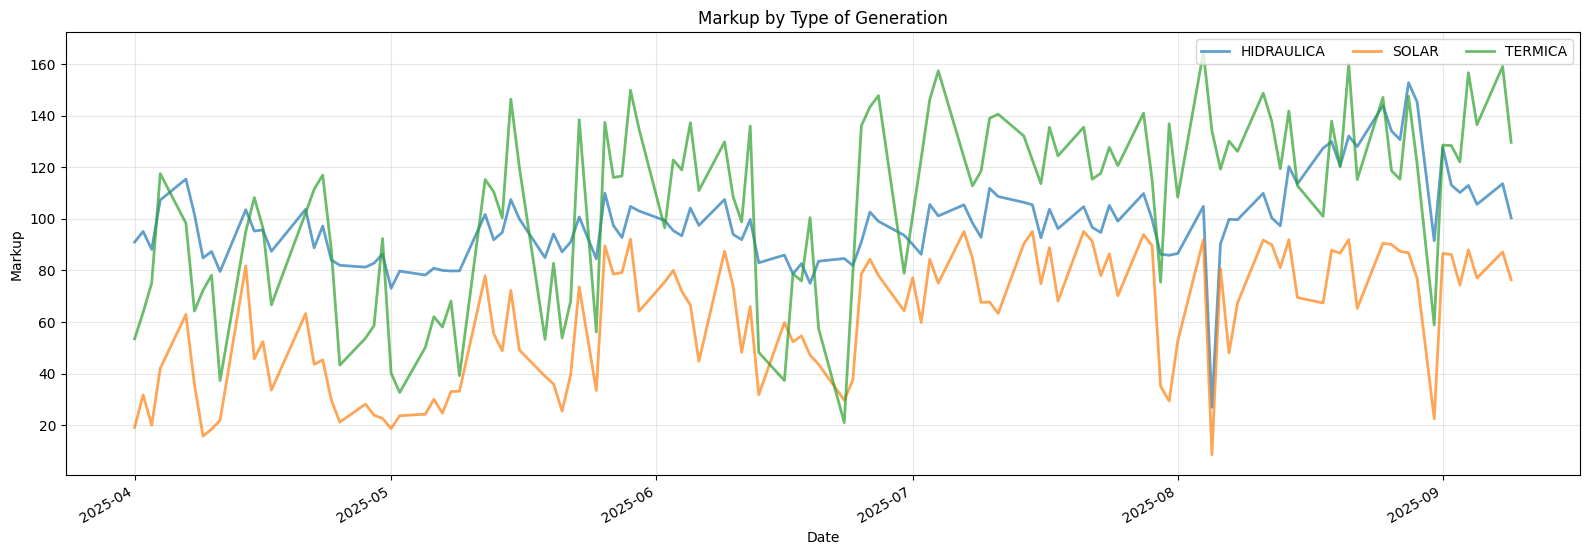

In [238]:

# Crear un color distinto por tipo de generación
tipos = df_merged['Tipo Generación'].unique()
colors = plt.cm.tab10(range(len(tipos)))
color_dict = {tipo: colors[i] for i, tipo in enumerate(tipos)}

# Fechas para el nombre del archivo
fecha_min_str = pd.to_datetime(df_merged['Fecha'].min()).strftime('%Y%m%d')
fecha_max_str = pd.to_datetime(df_merged['Fecha'].max()).strftime('%Y%m%d')

filename = f"{fecha_min_str}_to_{fecha_max_str}_M{M}_full_markup.png"
filepath = os.path.join(sub_dir, filename)

plt.figure(figsize=(16, 6))

# Graficar por tipo de generación
for tipo in tipos:

    df_tipo = (
        df_merged[df_merged['Tipo Generación'] == tipo]
        .groupby('Fecha', as_index=False)['rel_markup']
        .mean()
        .sort_values('Fecha')
    )
    print(df_tipo.head())

    c = color_dict[tipo]   # Color asignado

    plt.plot(
        df_tipo['Fecha'],
        df_tipo['rel_markup'],   # ← CORREGIDO
        alpha=0.7,
        linestyle='-',
        linewidth=2,
        color=c,
        label=f"{tipo}"
    )

# Configuración de la gráfica
plt.xlabel("Date")
plt.ylabel("Markup")
plt.title("Markup by Type of Generation")
plt.legend(loc='upper right', ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()

# Guardar y mostrar
plt.savefig(filepath, dpi=300, bbox_inches='tight')
print(filepath)
plt.show()



Tipo: HIDRAULICA
       Fecha  rel_markup
0 2025-04-01   94.132877
1 2025-04-02   96.346369
2 2025-04-03   95.377033
3 2025-04-04  103.985729
4 2025-04-07  113.139818

Tipo: SOLAR
       Fecha  rel_markup
0 2025-04-01   19.174664
1 2025-04-02   31.778080
2 2025-04-03   20.009437
3 2025-04-04   42.049965
4 2025-04-07   62.918470

Tipo: TERMICA
       Fecha  rel_markup
0 2025-04-01  160.100314
1 2025-04-02   53.831558
2 2025-04-03   55.063673
3 2025-04-04  219.435521
4 2025-04-07  257.695008
../results/fechas_117/20250401_to_20250909_M20_winners_markup.png


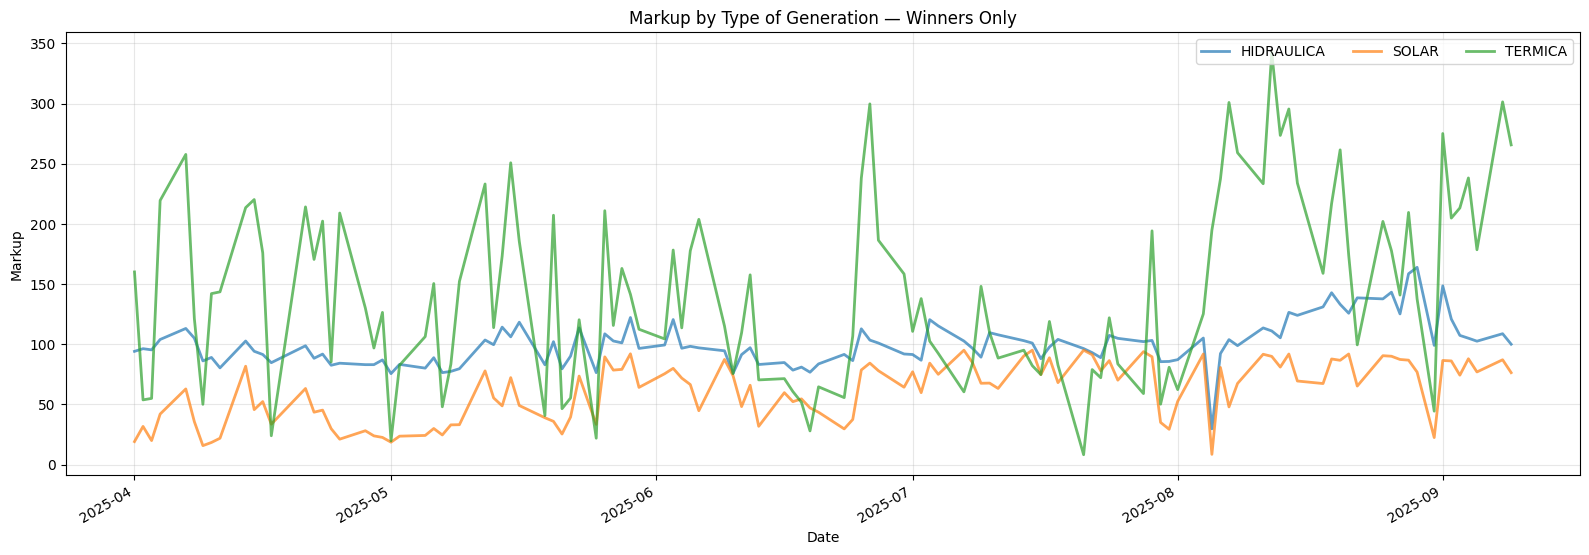

In [239]:
## markup de winners
import matplotlib.pyplot as plt

# Crear un color distinto por tipo de generación
tipos = df_merged_win['Tipo Generación'].unique()
colors = plt.cm.tab10(range(len(tipos)))
color_dict = {tipo: colors[i] for i, tipo in enumerate(tipos)}

# Fechas para el nombre del archivo (usando solo winners)
fecha_min_str = pd.to_datetime(df_merged_win['Fecha'].min()).strftime('%Y%m%d')
fecha_max_str = pd.to_datetime(df_merged_win['Fecha'].max()).strftime('%Y%m%d')

filename = f"{fecha_min_str}_to_{fecha_max_str}_M{M}_winners_markup.png"
filepath = os.path.join(sub_dir, filename)

plt.figure(figsize=(16, 6))

# Graficar por tipo de generación
for tipo in tipos:

    df_tipo = (
        df_merged_win[df_merged_win['Tipo Generación'] == tipo]
        .groupby('Fecha', as_index=False)['rel_markup']
        .mean()
        .sort_values('Fecha')
    )

    print("\nTipo:", tipo)
    print(df_tipo.head())

    # Color asignado
    c = color_dict[tipo]

    plt.plot(
        df_tipo['Fecha'],
        df_tipo['rel_markup'],
        alpha=0.7,
        linestyle='-',
        linewidth=2,
        color=c,
        label=f"{tipo}"
    )

# Configuración de la gráfica
plt.xlabel("Date")
plt.ylabel("Markup")
plt.title("Markup by Type of Generation — Winners Only")
plt.legend(loc='upper right', ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()

print(filepath)
# Guardar y mostrar
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()


In [240]:
for tipo, df_tipo in df_merged.groupby('Tipo Generación'):
    print("\n-----------------------------")
    print(f"Resumen para: {tipo}")
    print(df_tipo['abs_markup'].describe())



-----------------------------
Resumen para: HIDRAULICA
count    3387.000000
mean      242.007830
std       198.475775
min         1.899330
25%        84.155372
50%       206.206888
75%       323.806844
max      2512.235278
Name: abs_markup, dtype: float64

-----------------------------
Resumen para: SOLAR
count    1157.000000
mean       86.088522
std        73.157743
min         2.665660
25%        32.578827
50%        68.687754
75%       118.904783
max       525.824830
Name: abs_markup, dtype: float64

-----------------------------
Resumen para: TERMICA
count    3.546000e+03
mean     2.637064e+24
std      1.570327e+26
min      4.126239e-06
25%      3.370982e+01
50%      7.220312e+01
75%      1.453994e+02
max      9.351029e+27
Name: abs_markup, dtype: float64


In [241]:
df_merged.groupby('Tipo Generación')['abs_markup'].describe()


count          mean           std       min        25%  \
Tipo Generación                                                            
HIDRAULICA       3387.0  2.420078e+02  1.984758e+02  1.899330  84.155372   
SOLAR            1157.0  8.608852e+01  7.315774e+01  2.665660  32.578827   
TERMICA          3546.0  2.637064e+24  1.570327e+26  0.000004  33.709817   

                        50%         75%           max  
Tipo Generación                                        
HIDRAULICA       206.206888  323.806844  2.512235e+03  
SOLAR             68.687754  118.904783  5.258248e+02  
TERMICA           72.203123  145.399434  9.351029e+27

In [242]:
import os
sub_dir ='../results/fechas_117/HIDRAULICA/'
png_files = [f for f in os.listdir(sub_dir) if f.lower().endswith('.png')]
print(png_files)


['abs_markup_HIDRAULICA_20250401_to_20250909_M20.png', 'HIDRAULICA_markup_phi_bid_20250401_to_20250909_M20.png', 'phi_agg_precio_2QEK_20250401_to_20250909_M50.png', 'phi_agg_precio_ALBG_20250401_to_20250909_M50.png', 'phi_agg_precio_CHBG_20250401_to_20250909_M50.png', 'phi_agg_precio_CHVR_20250401_to_20250909_M50.png', 'phi_agg_precio_CLL1_20250401_to_20250909_M50.png', 'phi_agg_precio_CLMG_20250401_to_20250909_M50.png', 'phi_agg_precio_CUC1_20250401_to_20250909_M50.png', 'phi_agg_precio_DVS1_20250401_to_20250909_M50.png', 'phi_agg_precio_ESMR_20250409_to_20250909_M50.png', 'phi_agg_precio_GTPE_20250401_to_20250909_M50.png', 'phi_agg_precio_GTRG_20250401_to_20250909_M50.png', 'phi_agg_precio_GVIO_20250401_to_20250909_M50.png', 'phi_agg_precio_HMIN_20250401_to_20250909_M50.png', 'phi_agg_precio_HMLG_20250401_to_20250909_M50.png', 'phi_agg_precio_JAGS_20250401_to_20250909_M50.png', 'phi_agg_precio_LTSJ_20250401_to_20250909_M50.png', 'phi_agg_precio_MOY1_20250401_to_20250909_M50.png', 'ph

In [243]:
sub_dir ='../results/fechas_117/SOLAR/'
png_files = [f for f in os.listdir(sub_dir) if f.lower().endswith('.png')]
print(png_files)


['abs_markup_SOLAR_20250401_to_20250909_M20.png', 'phi_agg_precio_3DDT_20250401_to_20250909_M50.png', 'phi_agg_precio_3HF5_20250401_to_20250909_M50.png', 'phi_agg_precio_3INX_20250401_to_20250909_M50.png', 'phi_agg_precio_3IQA_20250401_to_20250909_M50.png', 'phi_agg_precio_3IRX_20250401_to_20250909_M50.png', 'phi_agg_precio_3IZ6_20250401_to_20250909_M50.png', 'phi_agg_precio_EPFV_20250401_to_20250909_M50.png', 'phi_agg_precio_GYPO_20250401_to_20250909_M50.png', 'phi_agg_precio_MATA_20250401_to_20250909_M50.png', 'phi_agg_precio_TPUY_20250401_to_20250909_M50.png', 'phi_precio_3DDT_20250401_to_20250909_M20.png', 'phi_precio_3HF5_20250401_to_20250909_M20.png', 'phi_precio_3INX_20250401_to_20250909_M20.png', 'phi_precio_3IQA_20250401_to_20250909_M20.png', 'phi_precio_3IRX_20250401_to_20250909_M20.png', 'phi_precio_3IZ6_20250401_to_20250909_M20.png', 'phi_precio_EPFV_20250401_to_20250909_M20.png', 'phi_precio_GYPO_20250401_to_20250909_M20.png', 'phi_precio_MATA_20250401_to_20250909_M20.png'

In [244]:
sub_dir ='../results/fechas_117/TERMICA/'
png_files = [f for f in os.listdir(sub_dir) if f.lower().endswith('.png')]
print(png_files)


['20250401_to_20250909_M20_full.png', '20250401_to_20250909_M20_winners.png', '20250401_to_20250909_M50_full.png', 'abs_markup_TERMICA_20250401_to_20250909_M20.png', 'phi_agg_precio_3ENA_20250401_to_20250909_M50.png', 'phi_agg_precio_CTG1_20250401_to_20250909_M50.png', 'phi_agg_precio_CTG2_20250401_to_20250909_M50.png', 'phi_agg_precio_GE32_20250401_to_20250514_M50.png', 'phi_agg_precio_GEC3_20250401_to_20250909_M50.png', 'phi_agg_precio_MRL1_20250401_to_20250909_M50.png', 'phi_agg_precio_PPA1_20250401_to_20250820_M50.png', 'phi_agg_precio_PPA2_20250401_to_20250820_M50.png', 'phi_agg_precio_PPA3_20250401_to_20250909_M50.png', 'phi_agg_precio_PPA4_20250401_to_20250909_M50.png', 'phi_agg_precio_PRG1_20250410_to_20250909_M50.png', 'phi_agg_precio_PRG2_20250428_to_20250909_M50.png', 'phi_agg_precio_TBQ3_20250401_to_20250909_M50.png', 'phi_agg_precio_TBQ4_20250401_to_20250909_M50.png', 'phi_agg_precio_TBST_20250401_to_20250909_M50.png', 'phi_agg_precio_TCDT_20250401_to_20250909_M50.png', 'p

In [245]:
print('ya')

ya
